<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses

## Usage
this is how to use this script

1. [Define user input](#user_input)
2. [Run wanted climate variables](#climate_variables)
    1. [Atmosphere's climate variables](#atmosphere_climate_variables)
    2. [Land climate's variables](#land_climate_variables)
    3. [Hydrosphere's climate variables](#hydrosphere_climate_variables)
    4. [Second effect's climate variables](#second_effect_climate_variables)
3. [Export data](#Export)

## Input data

* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* List of variables
* List of SSP's
* List of time horizons

## [Climate variables](#climate_variables)
### [Atmosphere's climate variables](#atmosphere_climate_variables)
* [Precipitation](#worldbank)
* [Temperature](#worldbank)
* [Wind](#wind)
* [Humidity](#humidity)
* [Solar radiation](#solar_radiation)
* Air quality deterioration
### [Land's climate variables](#land_climate_variables)
* [Landslides](#landslides)
* Coastal erosion
* Soil erosion
* Soil salinity
### [Hydrosphere's climate variables](#hydrosphere_climate_variables)
* [Relative sea level rise](#relative_sea_level_rise)
* [Seawater temperature](#sea_water_temperature)
* [Water availability](#water_availability)
* floods (fluvial)
* floods (coastal)
* forest fires
### [Second effects of climate variables](#second_effect_climate_variables)
* Storms
* Dust storms
* Wildfire
* Urban heat island
* Growinf season length
* [cyclone risk](#cyclone_risk)



* earthquakes (not climate related)

## Climate impacts
* calculate impact on yields

## [Climate change information concerning the projects in the study area](#climate_change_info_for_each_project_in_study_area)


## Contact

rapy@cowi.com


<a id='user_input'></a>
## User inputs

[Home](#beginning_CRVA)

In [1]:
#User inputs
import os.path


#project locations (shapefile with location of elements to evaluate)
data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
#data_folder=os.path.join(os.pardir,'dataset')
project_location_path=os.path.join(data_folder,'Mozambique_PPIS/EIB_locations_few.shp')
project_id='Name' #name of column used as id

#study boundary (optional)
study_area_path=os.path.join(data_folder,'Mozambique_PPIS/mozambique.shp')

#output folder
#out_path=r'\\COWI.net\projects\A245000\A248363\CRVA\Scripts\outputs'
out_path=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs'

#projection CRS (default = 'EPSG:4326')
bCRS='EPSG:4326'

#buffer for climate/grid variables
buffer=40000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:31983' #metric CRS for buffer in meters (find relevant metric CRS for location!)


#### Year of study
#IDEA IS TO GIVE POSSIBILITY FOR THE USER TO CHOOSE DEPENDING on PROJECT (could choose on year or a period but precise period make more sense)
#SET by default for the moment

first_year = 2025 # start year included
last_year = 2026 # last year included


# For data coming from copernicus, historical data are commonly 1850-2005

## Import python packages

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
#import numpy as np
#import io
import cdsapi # for copernicus function
import datetime # to have actual date

# import functions and class defined in another file named FunctionsAndClass
## Functions
from FunctionsAndClass import copernicus_data
from FunctionsAndClass import year_copernicus
from FunctionsAndClass import date_copernicus
from FunctionsAndClass import dataframe_csv_copernicus
from FunctionsAndClass import Display_map
from FunctionsAndClass import read_cckp_ncdata
from FunctionsAndClass import get_cckp_file_name

## Class
from FunctionsAndClass import time
from FunctionsAndClass import copernicus_elements
from FunctionsAndClass import map_elements

<a id='load_shapefile'></a>
## Load shapefiles and plot

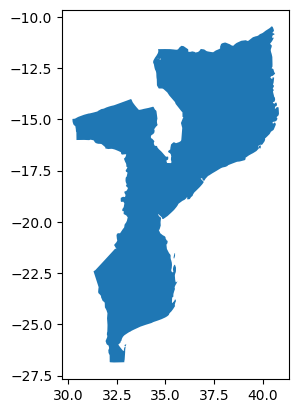

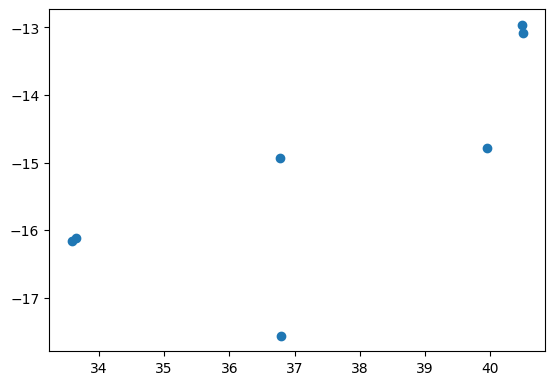

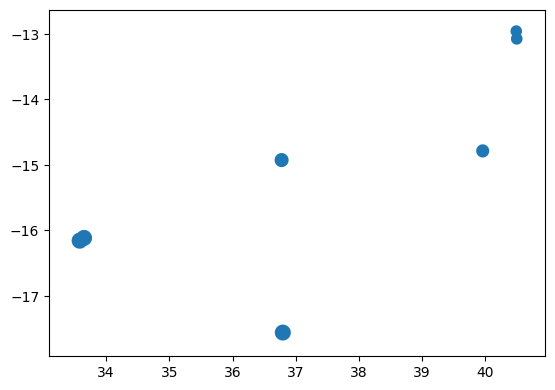

In [3]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)

#calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer) #assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS)#project back to orginal crs

    
#plot shapefiles
study_area.plot()
projects.plot()
projects_buf.plot() 

#show table
projects[[project_id]]

#### determination of the geographical zone of interest 
lat_min_wanted = min(study_area['LAT'])-10
lat_max_wanted = max(study_area['LAT'])+10
lon_min_wanted = min(study_area['LON'])-20
lon_max_wanted = max(study_area['LON'])+20
# addind and substracting to lon and lat to have margin
# substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90

area = [lat_min_wanted, lon_min_wanted, lat_max_wanted,lon_max_wanted,] # used to download from copernicus

### YEAR
year = np.arange(first_year,(last_year+1),1) # create vector of years
year_str = [0]*len(year) # create initiale empty vector to convert years in int
index = np.arange(0,len(year)) # create vector of index for year
i = 0 # initialize index
for i in index: # convert all the date in string format
    year_str[i]=str(year[i])

start_date = "01-01-"+year_str[0] # string start date based on start year
stop_date = "31-12-"+year_str[len(year)-1] # string stop date based on stop year
dates = pd.date_range(start_date,stop_date) # vector of dates between start date and stop date
index_dates = np.arange(0,len(dates)) # vector containning index o dates vector

<a id='climate_variables'></a>
# Climate variables

[Home](#beginning_CRVA)

<a id='atmosphere_climate_variables'></a>
# ATMOSPHERE

[Home](#beginning_CRVA)

<a id='worldbank'></a>
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
data source: https://climateknowledgeportal.worldbank.org/download-data

List of different variables:

### Precipitation 
* return period of current 50 and 100 year event
* yearly average precipitation
* seasonal average precipitation - OR MONTH? i word documnet: average dry season precipitation 
* maximum precipitation in one day - NOT REALLY, instead "Average of the largest daily precipitation amount" rx1day 
* maximum precipitation in five days - NOT REALLY, instead "Average of the largest 5-day consecutive precipitation amount".
* FORSLAG: Could also include: precipitation amount from very wet days/ days >50mm. eg. 

### Temperature
* Yearly mean temperature (average) - tas 
* Number of hot days >40 degrees C (average)
* Number of hot days >35 degrees C (average) 
* Maximum of daily max-temperature (per year) -txx
* Average of maximum temperature (daily??) - tasmax 

### How to use
define 

`variables = {variablename1:{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, variablename2:...}`

where variablename corresponds to a variable name in the cckp, periods include the desired periods, ssps the desired ssp-rcp scenarios, and gcms can be either median, p10, or p90 (50%, 10%, and 90% percentile of ensemble models).

In [ ]:
#Read downloaded precipitation and temperature data
#settings

variables= {
    #Temperature
        #era/cru
            #'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
            'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
            'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
            'climatology-tasmax-annual-mean_cru':{'periods':['1991-2020']}, 
        #realtime
            'climatology-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-hd40':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median']},
            #'anomaly-hd35':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-tasmax':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'anomaly-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #txx=maximum of daily max temperature
            'climatology-txx':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'anomaly-tas':{'periods':['2020-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-tas':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, #data not downloaded 
    #Precipitation
       #era/cru
            #'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
            'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
            'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
            'frp100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039','2035-2064'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}, 
            'frp50yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx5day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-rx1day-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-monthly-mean_cmip6_monthly':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-annual-mean_cmip6_annual':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':['2020-2039','2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':['2010-2039'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']},
            #'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':['2040-2059'],'ssps':['ssp245','ssp370'],'gcms':['median','p10','p90']}
            }
       ## 'timeseries-rx1day':{'periods':['2015-2100'],'ssps':['ssp245'],'gcms':['median']} # Den kan ikke læse den - brokker sig over Dimension time=0. 
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,None,None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,:,:],:]=stats.T.values
            else:
                print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            print(data_path,"not found")
                            projects[varname]='not found'
                           

#plot, show #ADD enlarge the clip + something wierd with nodata value
cckp_output.to_csv('outputs/csv/cckp_output.csv')
projects[[project_id,varname]].head()

fig, ax = plt.subplots()
precip = rioxarray.open_rasterio(data)
precip_clip = precip.rio.clip(study_area.geometry, study_area.crs, drop=True)
precip_clip.plot(ax=ax)
projects.plot(ax=ax)

#close
precip.close()

<a id='wind'></a>
## Wind Speed

Daily wind speed, historical and projected.

Data source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

In [4]:
### Extraction of Near-surface wind speed data
global_variable = 'Wind'
name_variable = 'near_surface_wind_speed'

#### Historical data for wind speed

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1950,2014)
temporal_resolution = 'daily'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Wind_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path, name_variable,'sfcWind',area)    

In [8]:
lala=np.arange(1950,2014)
len(lala)

64

In [11]:
index_lala=np.arange(0,len(lala)-1)
len(index_lala)

63

#### Projection data for wind speed

In [13]:
(year, year_str, index)=year_copernicus(2090,2100)
temporal_resolution = 'daily'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Wind = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,'sfcWind',area)    

ssp1_1_9
('access_cm2',)


2023-04-19 09:40:34,583 INFO Welcome to the CDS
2023-04-19 09:40:34,583 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-04-19 09:40:34,731 INFO Request is queued
2023-04-19 09:40:35,771 INFO Request is running
2023-04-19 09:40:37,323 INFO Request is failed
2023-04-19 09:40:37,323 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:37,323 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'ACCESS-CM2', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:37,323 ERROR   Traceback (most recent call last):
2023-04-19 09:40:37,323 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:37,323 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:37,323 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023

Some parameters are not matching
Path does not exist
('awi_cm_1_1_mr',)


2023-04-19 09:40:40,025 INFO Request is failed
2023-04-19 09:40:40,025 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:40,025 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'AWI-CM-1-1-MR', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:40,042 ERROR   Traceback (most recent call last):
2023-04-19 09:40:40,042 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:40,042 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:40,042 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:40,042 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:40,042 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:40,042 ERROR       return p(*args, **k

Some parameters are not matching
Path does not exist
('bcc_csm2_mr',)


2023-04-19 09:40:41,264 INFO Request is failed
2023-04-19 09:40:41,264 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:41,264 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'BCC-CSM2-MR', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:41,279 ERROR   Traceback (most recent call last):
2023-04-19 09:40:41,281 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:41,281 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:41,281 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:41,281 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:41,281 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:41,281 ERROR       return p(*args, **kwa

Some parameters are not matching
Path does not exist
('cams_csm1_0',)


2023-04-19 09:40:42,432 INFO Request is failed
2023-04-19 09:40:42,432 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:42,432 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CAMS-CSM1-0', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:42,432 ERROR   Traceback (most recent call last):
2023-04-19 09:40:42,448 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:42,448 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:42,448 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:42,448 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:42,448 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:42,448 ERROR       return p(*args, **kwa

Some parameters are not matching
Path does not exist
('canesm5_canoe',)


2023-04-19 09:40:43,583 INFO Request is running
2023-04-19 09:40:45,129 INFO Request is failed
2023-04-19 09:40:45,129 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:45,129 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CanESM5-CanOE', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:45,129 ERROR   Traceback (most recent call last):
2023-04-19 09:40:45,129 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:45,145 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:45,145 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:45,145 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:45,149 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04

Some parameters are not matching
Path does not exist
('cesm2_fv2',)


2023-04-19 09:40:46,300 INFO Request is running
2023-04-19 09:40:47,844 INFO Request is failed
2023-04-19 09:40:47,844 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:47,844 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-FV2', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:47,860 ERROR   Traceback (most recent call last):
2023-04-19 09:40:47,860 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:47,860 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:47,860 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:47,860 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:47,860 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 

Some parameters are not matching
Path does not exist
('cesm2_waccm_fv2',)


2023-04-19 09:40:48,987 INFO Request is failed
2023-04-19 09:40:48,987 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:48,995 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CESM2-WACCM-FV2', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:48,995 ERROR   Traceback (most recent call last):
2023-04-19 09:40:48,997 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:48,997 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:49,001 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:49,002 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:49,002 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:49,002 ERROR       return p(*args, *

Some parameters are not matching
Path does not exist
('cmcc_cm2_hr4',)


2023-04-19 09:40:50,137 INFO Request is failed
2023-04-19 09:40:50,138 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:50,138 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-CM2-HR4', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:50,138 ERROR   Traceback (most recent call last):
2023-04-19 09:40:50,147 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:50,149 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:50,149 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:50,149 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:50,149 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:50,149 ERROR       return p(*args, **kw

Some parameters are not matching
Path does not exist
('cmcc_esm2',)


2023-04-19 09:40:51,330 INFO Request is failed
2023-04-19 09:40:51,330 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:51,330 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CMCC-ESM2', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:51,330 ERROR   Traceback (most recent call last):
2023-04-19 09:40:51,330 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:51,330 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:51,346 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:51,346 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:51,346 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:51,346 ERROR       return p(*args, **kwarg

Some parameters are not matching
Path does not exist
('cnrm_cm6_1_hr',)


2023-04-19 09:40:52,492 INFO Request is running
2023-04-19 09:40:54,044 INFO Request is failed
2023-04-19 09:40:54,060 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:54,060 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'CNRM-CM6-1-HR', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:54,060 ERROR   Traceback (most recent call last):
2023-04-19 09:40:54,060 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:54,060 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:54,060 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:54,071 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:54,072 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04

Some parameters are not matching
Path does not exist
('e3sm_1_0',)


2023-04-19 09:40:56,767 INFO Request is failed
2023-04-19 09:40:56,767 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:56,767 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-0', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:56,767 ERROR   Traceback (most recent call last):
2023-04-19 09:40:56,783 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:56,783 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:56,783 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:56,783 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:56,783 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:56,783 ERROR       return p(*args, **kwargs

Some parameters are not matching
Path does not exist
('e3sm_1_1_eca',)


2023-04-19 09:40:57,997 INFO Request is failed
2023-04-19 09:40:57,997 ERROR Message: an internal error occurred processing your request
2023-04-19 09:40:57,997 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'E3SM-1-1-ECA', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:40:57,997 ERROR   Traceback (most recent call last):
2023-04-19 09:40:57,997 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:40:57,997 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:40:57,997 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:40:58,012 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:40:58,012 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:40:58,012 ERROR       return p(*args, **kw

Some parameters are not matching
Path does not exist
('ec_earth3_aerchem',)


2023-04-19 09:41:00,776 INFO Request is failed
2023-04-19 09:41:00,776 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:00,776 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'EC-Earth3-AerChem', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:00,792 ERROR   Traceback (most recent call last):
2023-04-19 09:41:00,792 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:00,792 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:00,792 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:00,792 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:00,792 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:00,792 ERROR       return p(*args,

Some parameters are not matching
Path does not exist
('ec_earth3_veg',)


2023-04-19 09:41:01,998 INFO Request is failed
2023-04-19 09:41:01,998 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:02,014 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'EC-Earth3-Veg', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:02,014 ERROR   Traceback (most recent call last):
2023-04-19 09:41:02,014 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:02,014 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:02,014 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:02,014 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:02,014 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:02,025 ERROR       return p(*args, **k

Some parameters are not matching
Path does not exist
('fgoals_f3_l',)


2023-04-19 09:41:03,237 INFO Request is failed
2023-04-19 09:41:03,237 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:03,237 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'FGOALS-f3-L', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:03,237 ERROR   Traceback (most recent call last):
2023-04-19 09:41:03,237 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:03,237 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:03,253 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:03,253 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:03,256 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:03,256 ERROR       return p(*args, **kwa

Some parameters are not matching
Path does not exist
('fio_esm_2_0',)


2023-04-19 09:41:04,442 INFO Request is failed
2023-04-19 09:41:04,442 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:04,442 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'FIO-ESM-2-0', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:04,442 ERROR   Traceback (most recent call last):
2023-04-19 09:41:04,442 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:04,442 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:04,458 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:04,458 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:04,458 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:04,458 ERROR       return p(*args, **kwa

Some parameters are not matching
Path does not exist
('giss_e2_1_g',)


2023-04-19 09:41:05,628 INFO Request is failed
2023-04-19 09:41:05,628 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:05,628 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'GISS-E2-1-G', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:05,645 ERROR   Traceback (most recent call last):
2023-04-19 09:41:05,647 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:05,647 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:05,647 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:05,647 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:05,647 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:05,647 ERROR       return p(*args, **kwa

Some parameters are not matching
Path does not exist
('hadgem3_gc31_ll',)


2023-04-19 09:41:06,796 INFO Request is failed
2023-04-19 09:41:06,796 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:06,812 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'HadGEM3-GC31-LL', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:06,817 ERROR   Traceback (most recent call last):
2023-04-19 09:41:06,818 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:06,822 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:06,824 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:06,824 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:06,824 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:06,824 ERROR       return p(*args, *

Some parameters are not matching
Path does not exist
('iitm_esm',)


2023-04-19 09:41:08,000 INFO Request is failed
2023-04-19 09:41:08,000 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:08,016 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'IITM-ESM', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:08,016 ERROR   Traceback (most recent call last):
2023-04-19 09:41:08,016 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:08,016 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:08,016 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:08,016 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:08,016 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:08,016 ERROR       return p(*args, **kwargs

Some parameters are not matching
Path does not exist
('inm_cm5_0',)


2023-04-19 09:41:09,211 INFO Request is failed
2023-04-19 09:41:09,211 ERROR Message: an internal error occurred processing your request
2023-04-19 09:41:09,211 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'INM-CM5-0', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:41:09,211 ERROR   Traceback (most recent call last):
2023-04-19 09:41:09,211 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:41:09,211 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:41:09,211 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:41:09,211 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:41:09,211 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:41:09,225 ERROR       return p(*args, **kwarg

Some parameters are not matching
Path does not exist
('ipsl_cm6a_lr',)


2023-04-19 09:41:10,415 INFO Request is running
2023-04-19 09:41:58,995 INFO Request is completed
2023-04-19 09:41:58,995 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data2/adaptor.esgf_wps.retrieve-1681890114.0247765-14638-12-6a27f0b4-6723-43e9-998b-d7f9e384db1e.zip to download.zip (4.1M)
2023-04-19 09:42:01,547 INFO Download rate 1.6M/s                                                                      


The path exists
(Timestamp('2090-01-01 00:00:00', freq='D'),)
(Timestamp('2090-01-02 00:00:00', freq='D'),)
(Timestamp('2090-01-03 00:00:00', freq='D'),)
(Timestamp('2090-01-04 00:00:00', freq='D'),)
(Timestamp('2090-01-05 00:00:00', freq='D'),)
(Timestamp('2090-01-06 00:00:00', freq='D'),)
(Timestamp('2090-01-07 00:00:00', freq='D'),)
(Timestamp('2090-01-08 00:00:00', freq='D'),)
(Timestamp('2090-01-09 00:00:00', freq='D'),)
(Timestamp('2090-01-10 00:00:00', freq='D'),)
(Timestamp('2090-01-11 00:00:00', freq='D'),)
(Timestamp('2090-01-12 00:00:00', freq='D'),)
(Timestamp('2090-01-13 00:00:00', freq='D'),)
(Timestamp('2090-01-14 00:00:00', freq='D'),)
(Timestamp('2090-01-15 00:00:00', freq='D'),)
(Timestamp('2090-01-16 00:00:00', freq='D'),)
(Timestamp('2090-01-17 00:00:00', freq='D'),)
(Timestamp('2090-01-18 00:00:00', freq='D'),)
(Timestamp('2090-01-19 00:00:00', freq='D'),)
(Timestamp('2090-01-20 00:00:00', freq='D'),)
(Timestamp('2090-01-21 00:00:00', freq='D'),)
(Timestamp('2090-0

(Timestamp('2090-07-11 00:00:00', freq='D'),)
(Timestamp('2090-07-12 00:00:00', freq='D'),)
(Timestamp('2090-07-13 00:00:00', freq='D'),)
(Timestamp('2090-07-14 00:00:00', freq='D'),)
(Timestamp('2090-07-15 00:00:00', freq='D'),)
(Timestamp('2090-07-16 00:00:00', freq='D'),)
(Timestamp('2090-07-17 00:00:00', freq='D'),)
(Timestamp('2090-07-18 00:00:00', freq='D'),)
(Timestamp('2090-07-19 00:00:00', freq='D'),)
(Timestamp('2090-07-20 00:00:00', freq='D'),)
(Timestamp('2090-07-21 00:00:00', freq='D'),)
(Timestamp('2090-07-22 00:00:00', freq='D'),)
(Timestamp('2090-07-23 00:00:00', freq='D'),)
(Timestamp('2090-07-24 00:00:00', freq='D'),)
(Timestamp('2090-07-25 00:00:00', freq='D'),)
(Timestamp('2090-07-26 00:00:00', freq='D'),)
(Timestamp('2090-07-27 00:00:00', freq='D'),)
(Timestamp('2090-07-28 00:00:00', freq='D'),)
(Timestamp('2090-07-29 00:00:00', freq='D'),)
(Timestamp('2090-07-30 00:00:00', freq='D'),)
(Timestamp('2090-07-31 00:00:00', freq='D'),)
(Timestamp('2090-08-01 00:00:00', 

(Timestamp('2091-01-26 00:00:00', freq='D'),)
(Timestamp('2091-01-27 00:00:00', freq='D'),)
(Timestamp('2091-01-28 00:00:00', freq='D'),)
(Timestamp('2091-01-29 00:00:00', freq='D'),)
(Timestamp('2091-01-30 00:00:00', freq='D'),)
(Timestamp('2091-01-31 00:00:00', freq='D'),)
(Timestamp('2091-02-01 00:00:00', freq='D'),)
(Timestamp('2091-02-02 00:00:00', freq='D'),)
(Timestamp('2091-02-03 00:00:00', freq='D'),)
(Timestamp('2091-02-04 00:00:00', freq='D'),)
(Timestamp('2091-02-05 00:00:00', freq='D'),)
(Timestamp('2091-02-06 00:00:00', freq='D'),)
(Timestamp('2091-02-07 00:00:00', freq='D'),)
(Timestamp('2091-02-08 00:00:00', freq='D'),)
(Timestamp('2091-02-09 00:00:00', freq='D'),)
(Timestamp('2091-02-10 00:00:00', freq='D'),)
(Timestamp('2091-02-11 00:00:00', freq='D'),)
(Timestamp('2091-02-12 00:00:00', freq='D'),)
(Timestamp('2091-02-13 00:00:00', freq='D'),)
(Timestamp('2091-02-14 00:00:00', freq='D'),)
(Timestamp('2091-02-15 00:00:00', freq='D'),)
(Timestamp('2091-02-16 00:00:00', 

(Timestamp('2091-08-11 00:00:00', freq='D'),)
(Timestamp('2091-08-12 00:00:00', freq='D'),)
(Timestamp('2091-08-13 00:00:00', freq='D'),)
(Timestamp('2091-08-14 00:00:00', freq='D'),)
(Timestamp('2091-08-15 00:00:00', freq='D'),)
(Timestamp('2091-08-16 00:00:00', freq='D'),)
(Timestamp('2091-08-17 00:00:00', freq='D'),)
(Timestamp('2091-08-18 00:00:00', freq='D'),)
(Timestamp('2091-08-19 00:00:00', freq='D'),)
(Timestamp('2091-08-20 00:00:00', freq='D'),)
(Timestamp('2091-08-21 00:00:00', freq='D'),)
(Timestamp('2091-08-22 00:00:00', freq='D'),)
(Timestamp('2091-08-23 00:00:00', freq='D'),)
(Timestamp('2091-08-24 00:00:00', freq='D'),)
(Timestamp('2091-08-25 00:00:00', freq='D'),)
(Timestamp('2091-08-26 00:00:00', freq='D'),)
(Timestamp('2091-08-27 00:00:00', freq='D'),)
(Timestamp('2091-08-28 00:00:00', freq='D'),)
(Timestamp('2091-08-29 00:00:00', freq='D'),)
(Timestamp('2091-08-30 00:00:00', freq='D'),)
(Timestamp('2091-08-31 00:00:00', freq='D'),)
(Timestamp('2091-09-01 00:00:00', 

(Timestamp('2092-03-01 00:00:00', freq='D'),)
(Timestamp('2092-03-02 00:00:00', freq='D'),)
(Timestamp('2092-03-03 00:00:00', freq='D'),)
(Timestamp('2092-03-04 00:00:00', freq='D'),)
(Timestamp('2092-03-05 00:00:00', freq='D'),)
(Timestamp('2092-03-06 00:00:00', freq='D'),)
(Timestamp('2092-03-07 00:00:00', freq='D'),)
(Timestamp('2092-03-08 00:00:00', freq='D'),)
(Timestamp('2092-03-09 00:00:00', freq='D'),)
(Timestamp('2092-03-10 00:00:00', freq='D'),)
(Timestamp('2092-03-11 00:00:00', freq='D'),)
(Timestamp('2092-03-12 00:00:00', freq='D'),)
(Timestamp('2092-03-13 00:00:00', freq='D'),)
(Timestamp('2092-03-14 00:00:00', freq='D'),)
(Timestamp('2092-03-15 00:00:00', freq='D'),)
(Timestamp('2092-03-16 00:00:00', freq='D'),)
(Timestamp('2092-03-17 00:00:00', freq='D'),)
(Timestamp('2092-03-18 00:00:00', freq='D'),)
(Timestamp('2092-03-19 00:00:00', freq='D'),)
(Timestamp('2092-03-20 00:00:00', freq='D'),)
(Timestamp('2092-03-21 00:00:00', freq='D'),)
(Timestamp('2092-03-22 00:00:00', 

(Timestamp('2092-09-02 00:00:00', freq='D'),)
(Timestamp('2092-09-03 00:00:00', freq='D'),)
(Timestamp('2092-09-04 00:00:00', freq='D'),)
(Timestamp('2092-09-05 00:00:00', freq='D'),)
(Timestamp('2092-09-06 00:00:00', freq='D'),)
(Timestamp('2092-09-07 00:00:00', freq='D'),)
(Timestamp('2092-09-08 00:00:00', freq='D'),)
(Timestamp('2092-09-09 00:00:00', freq='D'),)
(Timestamp('2092-09-10 00:00:00', freq='D'),)
(Timestamp('2092-09-11 00:00:00', freq='D'),)
(Timestamp('2092-09-12 00:00:00', freq='D'),)
(Timestamp('2092-09-13 00:00:00', freq='D'),)
(Timestamp('2092-09-14 00:00:00', freq='D'),)
(Timestamp('2092-09-15 00:00:00', freq='D'),)
(Timestamp('2092-09-16 00:00:00', freq='D'),)
(Timestamp('2092-09-17 00:00:00', freq='D'),)
(Timestamp('2092-09-18 00:00:00', freq='D'),)
(Timestamp('2092-09-19 00:00:00', freq='D'),)
(Timestamp('2092-09-20 00:00:00', freq='D'),)
(Timestamp('2092-09-21 00:00:00', freq='D'),)
(Timestamp('2092-09-22 00:00:00', freq='D'),)
(Timestamp('2092-09-23 00:00:00', 

(Timestamp('2093-03-23 00:00:00', freq='D'),)
(Timestamp('2093-03-24 00:00:00', freq='D'),)
(Timestamp('2093-03-25 00:00:00', freq='D'),)
(Timestamp('2093-03-26 00:00:00', freq='D'),)
(Timestamp('2093-03-27 00:00:00', freq='D'),)
(Timestamp('2093-03-28 00:00:00', freq='D'),)
(Timestamp('2093-03-29 00:00:00', freq='D'),)
(Timestamp('2093-03-30 00:00:00', freq='D'),)
(Timestamp('2093-03-31 00:00:00', freq='D'),)
(Timestamp('2093-04-01 00:00:00', freq='D'),)
(Timestamp('2093-04-02 00:00:00', freq='D'),)
(Timestamp('2093-04-03 00:00:00', freq='D'),)
(Timestamp('2093-04-04 00:00:00', freq='D'),)
(Timestamp('2093-04-05 00:00:00', freq='D'),)
(Timestamp('2093-04-06 00:00:00', freq='D'),)
(Timestamp('2093-04-07 00:00:00', freq='D'),)
(Timestamp('2093-04-08 00:00:00', freq='D'),)
(Timestamp('2093-04-09 00:00:00', freq='D'),)
(Timestamp('2093-04-10 00:00:00', freq='D'),)
(Timestamp('2093-04-11 00:00:00', freq='D'),)
(Timestamp('2093-04-12 00:00:00', freq='D'),)
(Timestamp('2093-04-13 00:00:00', 

(Timestamp('2093-09-21 00:00:00', freq='D'),)
(Timestamp('2093-09-22 00:00:00', freq='D'),)
(Timestamp('2093-09-23 00:00:00', freq='D'),)
(Timestamp('2093-09-24 00:00:00', freq='D'),)
(Timestamp('2093-09-25 00:00:00', freq='D'),)
(Timestamp('2093-09-26 00:00:00', freq='D'),)
(Timestamp('2093-09-27 00:00:00', freq='D'),)
(Timestamp('2093-09-28 00:00:00', freq='D'),)
(Timestamp('2093-09-29 00:00:00', freq='D'),)
(Timestamp('2093-09-30 00:00:00', freq='D'),)
(Timestamp('2093-10-01 00:00:00', freq='D'),)
(Timestamp('2093-10-02 00:00:00', freq='D'),)
(Timestamp('2093-10-03 00:00:00', freq='D'),)
(Timestamp('2093-10-04 00:00:00', freq='D'),)
(Timestamp('2093-10-05 00:00:00', freq='D'),)
(Timestamp('2093-10-06 00:00:00', freq='D'),)
(Timestamp('2093-10-07 00:00:00', freq='D'),)
(Timestamp('2093-10-08 00:00:00', freq='D'),)
(Timestamp('2093-10-09 00:00:00', freq='D'),)
(Timestamp('2093-10-10 00:00:00', freq='D'),)
(Timestamp('2093-10-11 00:00:00', freq='D'),)
(Timestamp('2093-10-12 00:00:00', 

(Timestamp('2094-04-14 00:00:00', freq='D'),)
(Timestamp('2094-04-15 00:00:00', freq='D'),)
(Timestamp('2094-04-16 00:00:00', freq='D'),)
(Timestamp('2094-04-17 00:00:00', freq='D'),)
(Timestamp('2094-04-18 00:00:00', freq='D'),)
(Timestamp('2094-04-19 00:00:00', freq='D'),)
(Timestamp('2094-04-20 00:00:00', freq='D'),)
(Timestamp('2094-04-21 00:00:00', freq='D'),)
(Timestamp('2094-04-22 00:00:00', freq='D'),)
(Timestamp('2094-04-23 00:00:00', freq='D'),)
(Timestamp('2094-04-24 00:00:00', freq='D'),)
(Timestamp('2094-04-25 00:00:00', freq='D'),)
(Timestamp('2094-04-26 00:00:00', freq='D'),)
(Timestamp('2094-04-27 00:00:00', freq='D'),)
(Timestamp('2094-04-28 00:00:00', freq='D'),)
(Timestamp('2094-04-29 00:00:00', freq='D'),)
(Timestamp('2094-04-30 00:00:00', freq='D'),)
(Timestamp('2094-05-01 00:00:00', freq='D'),)
(Timestamp('2094-05-02 00:00:00', freq='D'),)
(Timestamp('2094-05-03 00:00:00', freq='D'),)
(Timestamp('2094-05-04 00:00:00', freq='D'),)
(Timestamp('2094-05-05 00:00:00', 

(Timestamp('2094-11-10 00:00:00', freq='D'),)
(Timestamp('2094-11-11 00:00:00', freq='D'),)
(Timestamp('2094-11-12 00:00:00', freq='D'),)
(Timestamp('2094-11-13 00:00:00', freq='D'),)
(Timestamp('2094-11-14 00:00:00', freq='D'),)
(Timestamp('2094-11-15 00:00:00', freq='D'),)
(Timestamp('2094-11-16 00:00:00', freq='D'),)
(Timestamp('2094-11-17 00:00:00', freq='D'),)
(Timestamp('2094-11-18 00:00:00', freq='D'),)
(Timestamp('2094-11-19 00:00:00', freq='D'),)
(Timestamp('2094-11-20 00:00:00', freq='D'),)
(Timestamp('2094-11-21 00:00:00', freq='D'),)
(Timestamp('2094-11-22 00:00:00', freq='D'),)
(Timestamp('2094-11-23 00:00:00', freq='D'),)
(Timestamp('2094-11-24 00:00:00', freq='D'),)
(Timestamp('2094-11-25 00:00:00', freq='D'),)
(Timestamp('2094-11-26 00:00:00', freq='D'),)
(Timestamp('2094-11-27 00:00:00', freq='D'),)
(Timestamp('2094-11-28 00:00:00', freq='D'),)
(Timestamp('2094-11-29 00:00:00', freq='D'),)
(Timestamp('2094-11-30 00:00:00', freq='D'),)
(Timestamp('2094-12-01 00:00:00', 

(Timestamp('2095-05-15 00:00:00', freq='D'),)
(Timestamp('2095-05-16 00:00:00', freq='D'),)
(Timestamp('2095-05-17 00:00:00', freq='D'),)
(Timestamp('2095-05-18 00:00:00', freq='D'),)
(Timestamp('2095-05-19 00:00:00', freq='D'),)
(Timestamp('2095-05-20 00:00:00', freq='D'),)
(Timestamp('2095-05-21 00:00:00', freq='D'),)
(Timestamp('2095-05-22 00:00:00', freq='D'),)
(Timestamp('2095-05-23 00:00:00', freq='D'),)
(Timestamp('2095-05-24 00:00:00', freq='D'),)
(Timestamp('2095-05-25 00:00:00', freq='D'),)
(Timestamp('2095-05-26 00:00:00', freq='D'),)
(Timestamp('2095-05-27 00:00:00', freq='D'),)
(Timestamp('2095-05-28 00:00:00', freq='D'),)
(Timestamp('2095-05-29 00:00:00', freq='D'),)
(Timestamp('2095-05-30 00:00:00', freq='D'),)
(Timestamp('2095-05-31 00:00:00', freq='D'),)
(Timestamp('2095-06-01 00:00:00', freq='D'),)
(Timestamp('2095-06-02 00:00:00', freq='D'),)
(Timestamp('2095-06-03 00:00:00', freq='D'),)
(Timestamp('2095-06-04 00:00:00', freq='D'),)
(Timestamp('2095-06-05 00:00:00', 

(Timestamp('2095-11-15 00:00:00', freq='D'),)
(Timestamp('2095-11-16 00:00:00', freq='D'),)
(Timestamp('2095-11-17 00:00:00', freq='D'),)
(Timestamp('2095-11-18 00:00:00', freq='D'),)
(Timestamp('2095-11-19 00:00:00', freq='D'),)
(Timestamp('2095-11-20 00:00:00', freq='D'),)
(Timestamp('2095-11-21 00:00:00', freq='D'),)
(Timestamp('2095-11-22 00:00:00', freq='D'),)
(Timestamp('2095-11-23 00:00:00', freq='D'),)
(Timestamp('2095-11-24 00:00:00', freq='D'),)
(Timestamp('2095-11-25 00:00:00', freq='D'),)
(Timestamp('2095-11-26 00:00:00', freq='D'),)
(Timestamp('2095-11-27 00:00:00', freq='D'),)
(Timestamp('2095-11-28 00:00:00', freq='D'),)
(Timestamp('2095-11-29 00:00:00', freq='D'),)
(Timestamp('2095-11-30 00:00:00', freq='D'),)
(Timestamp('2095-12-01 00:00:00', freq='D'),)
(Timestamp('2095-12-02 00:00:00', freq='D'),)
(Timestamp('2095-12-03 00:00:00', freq='D'),)
(Timestamp('2095-12-04 00:00:00', freq='D'),)
(Timestamp('2095-12-05 00:00:00', freq='D'),)
(Timestamp('2095-12-06 00:00:00', 

(Timestamp('2096-05-12 00:00:00', freq='D'),)
(Timestamp('2096-05-13 00:00:00', freq='D'),)
(Timestamp('2096-05-14 00:00:00', freq='D'),)
(Timestamp('2096-05-15 00:00:00', freq='D'),)
(Timestamp('2096-05-16 00:00:00', freq='D'),)
(Timestamp('2096-05-17 00:00:00', freq='D'),)
(Timestamp('2096-05-18 00:00:00', freq='D'),)
(Timestamp('2096-05-19 00:00:00', freq='D'),)
(Timestamp('2096-05-20 00:00:00', freq='D'),)
(Timestamp('2096-05-21 00:00:00', freq='D'),)
(Timestamp('2096-05-22 00:00:00', freq='D'),)
(Timestamp('2096-05-23 00:00:00', freq='D'),)
(Timestamp('2096-05-24 00:00:00', freq='D'),)
(Timestamp('2096-05-25 00:00:00', freq='D'),)
(Timestamp('2096-05-26 00:00:00', freq='D'),)
(Timestamp('2096-05-27 00:00:00', freq='D'),)
(Timestamp('2096-05-28 00:00:00', freq='D'),)
(Timestamp('2096-05-29 00:00:00', freq='D'),)
(Timestamp('2096-05-30 00:00:00', freq='D'),)
(Timestamp('2096-05-31 00:00:00', freq='D'),)
(Timestamp('2096-06-01 00:00:00', freq='D'),)
(Timestamp('2096-06-02 00:00:00', 

(Timestamp('2096-11-15 00:00:00', freq='D'),)
(Timestamp('2096-11-16 00:00:00', freq='D'),)
(Timestamp('2096-11-17 00:00:00', freq='D'),)
(Timestamp('2096-11-18 00:00:00', freq='D'),)
(Timestamp('2096-11-19 00:00:00', freq='D'),)
(Timestamp('2096-11-20 00:00:00', freq='D'),)
(Timestamp('2096-11-21 00:00:00', freq='D'),)
(Timestamp('2096-11-22 00:00:00', freq='D'),)
(Timestamp('2096-11-23 00:00:00', freq='D'),)
(Timestamp('2096-11-24 00:00:00', freq='D'),)
(Timestamp('2096-11-25 00:00:00', freq='D'),)
(Timestamp('2096-11-26 00:00:00', freq='D'),)
(Timestamp('2096-11-27 00:00:00', freq='D'),)
(Timestamp('2096-11-28 00:00:00', freq='D'),)
(Timestamp('2096-11-29 00:00:00', freq='D'),)
(Timestamp('2096-11-30 00:00:00', freq='D'),)
(Timestamp('2096-12-01 00:00:00', freq='D'),)
(Timestamp('2096-12-02 00:00:00', freq='D'),)
(Timestamp('2096-12-03 00:00:00', freq='D'),)
(Timestamp('2096-12-04 00:00:00', freq='D'),)
(Timestamp('2096-12-05 00:00:00', freq='D'),)
(Timestamp('2096-12-06 00:00:00', 

(Timestamp('2097-05-20 00:00:00', freq='D'),)
(Timestamp('2097-05-21 00:00:00', freq='D'),)
(Timestamp('2097-05-22 00:00:00', freq='D'),)
(Timestamp('2097-05-23 00:00:00', freq='D'),)
(Timestamp('2097-05-24 00:00:00', freq='D'),)
(Timestamp('2097-05-25 00:00:00', freq='D'),)
(Timestamp('2097-05-26 00:00:00', freq='D'),)
(Timestamp('2097-05-27 00:00:00', freq='D'),)
(Timestamp('2097-05-28 00:00:00', freq='D'),)
(Timestamp('2097-05-29 00:00:00', freq='D'),)
(Timestamp('2097-05-30 00:00:00', freq='D'),)
(Timestamp('2097-05-31 00:00:00', freq='D'),)
(Timestamp('2097-06-01 00:00:00', freq='D'),)
(Timestamp('2097-06-02 00:00:00', freq='D'),)
(Timestamp('2097-06-03 00:00:00', freq='D'),)
(Timestamp('2097-06-04 00:00:00', freq='D'),)
(Timestamp('2097-06-05 00:00:00', freq='D'),)
(Timestamp('2097-06-06 00:00:00', freq='D'),)
(Timestamp('2097-06-07 00:00:00', freq='D'),)
(Timestamp('2097-06-08 00:00:00', freq='D'),)
(Timestamp('2097-06-09 00:00:00', freq='D'),)
(Timestamp('2097-06-10 00:00:00', 

(Timestamp('2097-11-16 00:00:00', freq='D'),)
(Timestamp('2097-11-17 00:00:00', freq='D'),)
(Timestamp('2097-11-18 00:00:00', freq='D'),)
(Timestamp('2097-11-19 00:00:00', freq='D'),)
(Timestamp('2097-11-20 00:00:00', freq='D'),)
(Timestamp('2097-11-21 00:00:00', freq='D'),)
(Timestamp('2097-11-22 00:00:00', freq='D'),)
(Timestamp('2097-11-23 00:00:00', freq='D'),)
(Timestamp('2097-11-24 00:00:00', freq='D'),)
(Timestamp('2097-11-25 00:00:00', freq='D'),)
(Timestamp('2097-11-26 00:00:00', freq='D'),)
(Timestamp('2097-11-27 00:00:00', freq='D'),)
(Timestamp('2097-11-28 00:00:00', freq='D'),)
(Timestamp('2097-11-29 00:00:00', freq='D'),)
(Timestamp('2097-11-30 00:00:00', freq='D'),)
(Timestamp('2097-12-01 00:00:00', freq='D'),)
(Timestamp('2097-12-02 00:00:00', freq='D'),)
(Timestamp('2097-12-03 00:00:00', freq='D'),)
(Timestamp('2097-12-04 00:00:00', freq='D'),)
(Timestamp('2097-12-05 00:00:00', freq='D'),)
(Timestamp('2097-12-06 00:00:00', freq='D'),)
(Timestamp('2097-12-07 00:00:00', 

(Timestamp('2098-05-26 00:00:00', freq='D'),)
(Timestamp('2098-05-27 00:00:00', freq='D'),)
(Timestamp('2098-05-28 00:00:00', freq='D'),)
(Timestamp('2098-05-29 00:00:00', freq='D'),)
(Timestamp('2098-05-30 00:00:00', freq='D'),)
(Timestamp('2098-05-31 00:00:00', freq='D'),)
(Timestamp('2098-06-01 00:00:00', freq='D'),)
(Timestamp('2098-06-02 00:00:00', freq='D'),)
(Timestamp('2098-06-03 00:00:00', freq='D'),)
(Timestamp('2098-06-04 00:00:00', freq='D'),)
(Timestamp('2098-06-05 00:00:00', freq='D'),)
(Timestamp('2098-06-06 00:00:00', freq='D'),)
(Timestamp('2098-06-07 00:00:00', freq='D'),)
(Timestamp('2098-06-08 00:00:00', freq='D'),)
(Timestamp('2098-06-09 00:00:00', freq='D'),)
(Timestamp('2098-06-10 00:00:00', freq='D'),)
(Timestamp('2098-06-11 00:00:00', freq='D'),)
(Timestamp('2098-06-12 00:00:00', freq='D'),)
(Timestamp('2098-06-13 00:00:00', freq='D'),)
(Timestamp('2098-06-14 00:00:00', freq='D'),)
(Timestamp('2098-06-15 00:00:00', freq='D'),)
(Timestamp('2098-06-16 00:00:00', 

(Timestamp('2098-11-29 00:00:00', freq='D'),)
(Timestamp('2098-11-30 00:00:00', freq='D'),)
(Timestamp('2098-12-01 00:00:00', freq='D'),)
(Timestamp('2098-12-02 00:00:00', freq='D'),)
(Timestamp('2098-12-03 00:00:00', freq='D'),)
(Timestamp('2098-12-04 00:00:00', freq='D'),)
(Timestamp('2098-12-05 00:00:00', freq='D'),)
(Timestamp('2098-12-06 00:00:00', freq='D'),)
(Timestamp('2098-12-07 00:00:00', freq='D'),)
(Timestamp('2098-12-08 00:00:00', freq='D'),)
(Timestamp('2098-12-09 00:00:00', freq='D'),)
(Timestamp('2098-12-10 00:00:00', freq='D'),)
(Timestamp('2098-12-11 00:00:00', freq='D'),)
(Timestamp('2098-12-12 00:00:00', freq='D'),)
(Timestamp('2098-12-13 00:00:00', freq='D'),)
(Timestamp('2098-12-14 00:00:00', freq='D'),)
(Timestamp('2098-12-15 00:00:00', freq='D'),)
(Timestamp('2098-12-16 00:00:00', freq='D'),)
(Timestamp('2098-12-17 00:00:00', freq='D'),)
(Timestamp('2098-12-18 00:00:00', freq='D'),)
(Timestamp('2098-12-19 00:00:00', freq='D'),)
(Timestamp('2098-12-20 00:00:00', 

(Timestamp('2099-06-08 00:00:00', freq='D'),)
(Timestamp('2099-06-09 00:00:00', freq='D'),)
(Timestamp('2099-06-10 00:00:00', freq='D'),)
(Timestamp('2099-06-11 00:00:00', freq='D'),)
(Timestamp('2099-06-12 00:00:00', freq='D'),)
(Timestamp('2099-06-13 00:00:00', freq='D'),)
(Timestamp('2099-06-14 00:00:00', freq='D'),)
(Timestamp('2099-06-15 00:00:00', freq='D'),)
(Timestamp('2099-06-16 00:00:00', freq='D'),)
(Timestamp('2099-06-17 00:00:00', freq='D'),)
(Timestamp('2099-06-18 00:00:00', freq='D'),)
(Timestamp('2099-06-19 00:00:00', freq='D'),)
(Timestamp('2099-06-20 00:00:00', freq='D'),)
(Timestamp('2099-06-21 00:00:00', freq='D'),)
(Timestamp('2099-06-22 00:00:00', freq='D'),)
(Timestamp('2099-06-23 00:00:00', freq='D'),)
(Timestamp('2099-06-24 00:00:00', freq='D'),)
(Timestamp('2099-06-25 00:00:00', freq='D'),)
(Timestamp('2099-06-26 00:00:00', freq='D'),)
(Timestamp('2099-06-27 00:00:00', freq='D'),)
(Timestamp('2099-06-28 00:00:00', freq='D'),)
(Timestamp('2099-06-29 00:00:00', 

(Timestamp('2099-12-08 00:00:00', freq='D'),)
(Timestamp('2099-12-09 00:00:00', freq='D'),)
(Timestamp('2099-12-10 00:00:00', freq='D'),)
(Timestamp('2099-12-11 00:00:00', freq='D'),)
(Timestamp('2099-12-12 00:00:00', freq='D'),)
(Timestamp('2099-12-13 00:00:00', freq='D'),)
(Timestamp('2099-12-14 00:00:00', freq='D'),)
(Timestamp('2099-12-15 00:00:00', freq='D'),)
(Timestamp('2099-12-16 00:00:00', freq='D'),)
(Timestamp('2099-12-17 00:00:00', freq='D'),)
(Timestamp('2099-12-18 00:00:00', freq='D'),)
(Timestamp('2099-12-19 00:00:00', freq='D'),)
(Timestamp('2099-12-20 00:00:00', freq='D'),)
(Timestamp('2099-12-21 00:00:00', freq='D'),)
(Timestamp('2099-12-22 00:00:00', freq='D'),)
(Timestamp('2099-12-23 00:00:00', freq='D'),)
(Timestamp('2099-12-24 00:00:00', freq='D'),)
(Timestamp('2099-12-25 00:00:00', freq='D'),)
(Timestamp('2099-12-26 00:00:00', freq='D'),)
(Timestamp('2099-12-27 00:00:00', freq='D'),)
(Timestamp('2099-12-28 00:00:00', freq='D'),)
(Timestamp('2099-12-29 00:00:00', 

(Timestamp('2100-06-17 00:00:00', freq='D'),)
(Timestamp('2100-06-18 00:00:00', freq='D'),)
(Timestamp('2100-06-19 00:00:00', freq='D'),)
(Timestamp('2100-06-20 00:00:00', freq='D'),)
(Timestamp('2100-06-21 00:00:00', freq='D'),)
(Timestamp('2100-06-22 00:00:00', freq='D'),)
(Timestamp('2100-06-23 00:00:00', freq='D'),)
(Timestamp('2100-06-24 00:00:00', freq='D'),)
(Timestamp('2100-06-25 00:00:00', freq='D'),)
(Timestamp('2100-06-26 00:00:00', freq='D'),)
(Timestamp('2100-06-27 00:00:00', freq='D'),)
(Timestamp('2100-06-28 00:00:00', freq='D'),)
(Timestamp('2100-06-29 00:00:00', freq='D'),)
(Timestamp('2100-06-30 00:00:00', freq='D'),)
(Timestamp('2100-07-01 00:00:00', freq='D'),)
(Timestamp('2100-07-02 00:00:00', freq='D'),)
(Timestamp('2100-07-03 00:00:00', freq='D'),)
(Timestamp('2100-07-04 00:00:00', freq='D'),)
(Timestamp('2100-07-05 00:00:00', freq='D'),)
(Timestamp('2100-07-06 00:00:00', freq='D'),)
(Timestamp('2100-07-07 00:00:00', freq='D'),)
(Timestamp('2100-07-08 00:00:00', 

2023-04-19 09:42:39,943 INFO Welcome to the CDS
2023-04-19 09:42:39,943 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6


(Timestamp('2100-12-25 00:00:00', freq='D'),)
(Timestamp('2100-12-26 00:00:00', freq='D'),)
(Timestamp('2100-12-27 00:00:00', freq='D'),)
(Timestamp('2100-12-28 00:00:00', freq='D'),)
(Timestamp('2100-12-29 00:00:00', freq='D'),)
(Timestamp('2100-12-30 00:00:00', freq='D'),)
(Timestamp('2100-12-31 00:00:00', freq='D'),)
('kiost_esm',)


2023-04-19 09:42:40,011 INFO Request is queued
2023-04-19 09:42:41,065 INFO Request is running
2023-04-19 09:42:42,612 INFO Request is failed
2023-04-19 09:42:42,612 ERROR Message: an internal error occurred processing your request
2023-04-19 09:42:42,612 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'KIOST-ESM', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:42:42,628 ERROR   Traceback (most recent call last):
2023-04-19 09:42:42,632 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:42:42,632 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:42:42,632 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:42:42,632 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:42:42,632 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/

Some parameters are not matching
Path does not exist
('miroc6',)


2023-04-19 09:42:43,776 INFO Request is failed
2023-04-19 09:42:43,792 ERROR Message: an internal error occurred processing your request
2023-04-19 09:42:43,792 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MIROC6', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:42:43,792 ERROR   Traceback (most recent call last):
2023-04-19 09:42:43,792 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:42:43,792 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:42:43,792 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:42:43,792 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:42:43,792 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:42:43,792 ERROR       return p(*args, **kwargs)


Some parameters are not matching
Path does not exist
('miroc_es2l',)


2023-04-19 09:42:44,985 INFO Request is running
2023-04-19 09:42:57,351 INFO Request is completed
2023-04-19 09:42:57,351 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data3/adaptor.esgf_wps.retrieve-1681890174.99248-466-8-04ee6a9b-7c92-4410-bdec-b7b32ed507ff.zip to download.zip (1.4M)
2023-04-19 09:42:58,462 INFO Download rate 1.3M/s                                                                      


The path exists
(Timestamp('2090-01-01 00:00:00', freq='D'),)
(Timestamp('2090-01-02 00:00:00', freq='D'),)
(Timestamp('2090-01-03 00:00:00', freq='D'),)
(Timestamp('2090-01-04 00:00:00', freq='D'),)
(Timestamp('2090-01-05 00:00:00', freq='D'),)
(Timestamp('2090-01-06 00:00:00', freq='D'),)
(Timestamp('2090-01-07 00:00:00', freq='D'),)
(Timestamp('2090-01-08 00:00:00', freq='D'),)
(Timestamp('2090-01-09 00:00:00', freq='D'),)
(Timestamp('2090-01-10 00:00:00', freq='D'),)
(Timestamp('2090-01-11 00:00:00', freq='D'),)
(Timestamp('2090-01-12 00:00:00', freq='D'),)
(Timestamp('2090-01-13 00:00:00', freq='D'),)
(Timestamp('2090-01-14 00:00:00', freq='D'),)
(Timestamp('2090-01-15 00:00:00', freq='D'),)
(Timestamp('2090-01-16 00:00:00', freq='D'),)
(Timestamp('2090-01-17 00:00:00', freq='D'),)
(Timestamp('2090-01-18 00:00:00', freq='D'),)
(Timestamp('2090-01-19 00:00:00', freq='D'),)
(Timestamp('2090-01-20 00:00:00', freq='D'),)
(Timestamp('2090-01-21 00:00:00', freq='D'),)
(Timestamp('2090-0

(Timestamp('2090-07-03 00:00:00', freq='D'),)
(Timestamp('2090-07-04 00:00:00', freq='D'),)
(Timestamp('2090-07-05 00:00:00', freq='D'),)
(Timestamp('2090-07-06 00:00:00', freq='D'),)
(Timestamp('2090-07-07 00:00:00', freq='D'),)
(Timestamp('2090-07-08 00:00:00', freq='D'),)
(Timestamp('2090-07-09 00:00:00', freq='D'),)
(Timestamp('2090-07-10 00:00:00', freq='D'),)
(Timestamp('2090-07-11 00:00:00', freq='D'),)
(Timestamp('2090-07-12 00:00:00', freq='D'),)
(Timestamp('2090-07-13 00:00:00', freq='D'),)
(Timestamp('2090-07-14 00:00:00', freq='D'),)
(Timestamp('2090-07-15 00:00:00', freq='D'),)
(Timestamp('2090-07-16 00:00:00', freq='D'),)
(Timestamp('2090-07-17 00:00:00', freq='D'),)
(Timestamp('2090-07-18 00:00:00', freq='D'),)
(Timestamp('2090-07-19 00:00:00', freq='D'),)
(Timestamp('2090-07-20 00:00:00', freq='D'),)
(Timestamp('2090-07-21 00:00:00', freq='D'),)
(Timestamp('2090-07-22 00:00:00', freq='D'),)
(Timestamp('2090-07-23 00:00:00', freq='D'),)
(Timestamp('2090-07-24 00:00:00', 

(Timestamp('2090-12-29 00:00:00', freq='D'),)
(Timestamp('2090-12-30 00:00:00', freq='D'),)
(Timestamp('2090-12-31 00:00:00', freq='D'),)
(Timestamp('2091-01-01 00:00:00', freq='D'),)
(Timestamp('2091-01-02 00:00:00', freq='D'),)
(Timestamp('2091-01-03 00:00:00', freq='D'),)
(Timestamp('2091-01-04 00:00:00', freq='D'),)
(Timestamp('2091-01-05 00:00:00', freq='D'),)
(Timestamp('2091-01-06 00:00:00', freq='D'),)
(Timestamp('2091-01-07 00:00:00', freq='D'),)
(Timestamp('2091-01-08 00:00:00', freq='D'),)
(Timestamp('2091-01-09 00:00:00', freq='D'),)
(Timestamp('2091-01-10 00:00:00', freq='D'),)
(Timestamp('2091-01-11 00:00:00', freq='D'),)
(Timestamp('2091-01-12 00:00:00', freq='D'),)
(Timestamp('2091-01-13 00:00:00', freq='D'),)
(Timestamp('2091-01-14 00:00:00', freq='D'),)
(Timestamp('2091-01-15 00:00:00', freq='D'),)
(Timestamp('2091-01-16 00:00:00', freq='D'),)
(Timestamp('2091-01-17 00:00:00', freq='D'),)
(Timestamp('2091-01-18 00:00:00', freq='D'),)
(Timestamp('2091-01-19 00:00:00', 

(Timestamp('2091-07-04 00:00:00', freq='D'),)
(Timestamp('2091-07-05 00:00:00', freq='D'),)
(Timestamp('2091-07-06 00:00:00', freq='D'),)
(Timestamp('2091-07-07 00:00:00', freq='D'),)
(Timestamp('2091-07-08 00:00:00', freq='D'),)
(Timestamp('2091-07-09 00:00:00', freq='D'),)
(Timestamp('2091-07-10 00:00:00', freq='D'),)
(Timestamp('2091-07-11 00:00:00', freq='D'),)
(Timestamp('2091-07-12 00:00:00', freq='D'),)
(Timestamp('2091-07-13 00:00:00', freq='D'),)
(Timestamp('2091-07-14 00:00:00', freq='D'),)
(Timestamp('2091-07-15 00:00:00', freq='D'),)
(Timestamp('2091-07-16 00:00:00', freq='D'),)
(Timestamp('2091-07-17 00:00:00', freq='D'),)
(Timestamp('2091-07-18 00:00:00', freq='D'),)
(Timestamp('2091-07-19 00:00:00', freq='D'),)
(Timestamp('2091-07-20 00:00:00', freq='D'),)
(Timestamp('2091-07-21 00:00:00', freq='D'),)
(Timestamp('2091-07-22 00:00:00', freq='D'),)
(Timestamp('2091-07-23 00:00:00', freq='D'),)
(Timestamp('2091-07-24 00:00:00', freq='D'),)
(Timestamp('2091-07-25 00:00:00', 

(Timestamp('2092-01-05 00:00:00', freq='D'),)
(Timestamp('2092-01-06 00:00:00', freq='D'),)
(Timestamp('2092-01-07 00:00:00', freq='D'),)
(Timestamp('2092-01-08 00:00:00', freq='D'),)
(Timestamp('2092-01-09 00:00:00', freq='D'),)
(Timestamp('2092-01-10 00:00:00', freq='D'),)
(Timestamp('2092-01-11 00:00:00', freq='D'),)
(Timestamp('2092-01-12 00:00:00', freq='D'),)
(Timestamp('2092-01-13 00:00:00', freq='D'),)
(Timestamp('2092-01-14 00:00:00', freq='D'),)
(Timestamp('2092-01-15 00:00:00', freq='D'),)
(Timestamp('2092-01-16 00:00:00', freq='D'),)
(Timestamp('2092-01-17 00:00:00', freq='D'),)
(Timestamp('2092-01-18 00:00:00', freq='D'),)
(Timestamp('2092-01-19 00:00:00', freq='D'),)
(Timestamp('2092-01-20 00:00:00', freq='D'),)
(Timestamp('2092-01-21 00:00:00', freq='D'),)
(Timestamp('2092-01-22 00:00:00', freq='D'),)
(Timestamp('2092-01-23 00:00:00', freq='D'),)
(Timestamp('2092-01-24 00:00:00', freq='D'),)
(Timestamp('2092-01-25 00:00:00', freq='D'),)
(Timestamp('2092-01-26 00:00:00', 

(Timestamp('2092-07-13 00:00:00', freq='D'),)
(Timestamp('2092-07-14 00:00:00', freq='D'),)
(Timestamp('2092-07-15 00:00:00', freq='D'),)
(Timestamp('2092-07-16 00:00:00', freq='D'),)
(Timestamp('2092-07-17 00:00:00', freq='D'),)
(Timestamp('2092-07-18 00:00:00', freq='D'),)
(Timestamp('2092-07-19 00:00:00', freq='D'),)
(Timestamp('2092-07-20 00:00:00', freq='D'),)
(Timestamp('2092-07-21 00:00:00', freq='D'),)
(Timestamp('2092-07-22 00:00:00', freq='D'),)
(Timestamp('2092-07-23 00:00:00', freq='D'),)
(Timestamp('2092-07-24 00:00:00', freq='D'),)
(Timestamp('2092-07-25 00:00:00', freq='D'),)
(Timestamp('2092-07-26 00:00:00', freq='D'),)
(Timestamp('2092-07-27 00:00:00', freq='D'),)
(Timestamp('2092-07-28 00:00:00', freq='D'),)
(Timestamp('2092-07-29 00:00:00', freq='D'),)
(Timestamp('2092-07-30 00:00:00', freq='D'),)
(Timestamp('2092-07-31 00:00:00', freq='D'),)
(Timestamp('2092-08-01 00:00:00', freq='D'),)
(Timestamp('2092-08-02 00:00:00', freq='D'),)
(Timestamp('2092-08-03 00:00:00', 

(Timestamp('2093-01-19 00:00:00', freq='D'),)
(Timestamp('2093-01-20 00:00:00', freq='D'),)
(Timestamp('2093-01-21 00:00:00', freq='D'),)
(Timestamp('2093-01-22 00:00:00', freq='D'),)
(Timestamp('2093-01-23 00:00:00', freq='D'),)
(Timestamp('2093-01-24 00:00:00', freq='D'),)
(Timestamp('2093-01-25 00:00:00', freq='D'),)
(Timestamp('2093-01-26 00:00:00', freq='D'),)
(Timestamp('2093-01-27 00:00:00', freq='D'),)
(Timestamp('2093-01-28 00:00:00', freq='D'),)
(Timestamp('2093-01-29 00:00:00', freq='D'),)
(Timestamp('2093-01-30 00:00:00', freq='D'),)
(Timestamp('2093-01-31 00:00:00', freq='D'),)
(Timestamp('2093-02-01 00:00:00', freq='D'),)
(Timestamp('2093-02-02 00:00:00', freq='D'),)
(Timestamp('2093-02-03 00:00:00', freq='D'),)
(Timestamp('2093-02-04 00:00:00', freq='D'),)
(Timestamp('2093-02-05 00:00:00', freq='D'),)
(Timestamp('2093-02-06 00:00:00', freq='D'),)
(Timestamp('2093-02-07 00:00:00', freq='D'),)
(Timestamp('2093-02-08 00:00:00', freq='D'),)
(Timestamp('2093-02-09 00:00:00', 

(Timestamp('2093-07-29 00:00:00', freq='D'),)
(Timestamp('2093-07-30 00:00:00', freq='D'),)
(Timestamp('2093-07-31 00:00:00', freq='D'),)
(Timestamp('2093-08-01 00:00:00', freq='D'),)
(Timestamp('2093-08-02 00:00:00', freq='D'),)
(Timestamp('2093-08-03 00:00:00', freq='D'),)
(Timestamp('2093-08-04 00:00:00', freq='D'),)
(Timestamp('2093-08-05 00:00:00', freq='D'),)
(Timestamp('2093-08-06 00:00:00', freq='D'),)
(Timestamp('2093-08-07 00:00:00', freq='D'),)
(Timestamp('2093-08-08 00:00:00', freq='D'),)
(Timestamp('2093-08-09 00:00:00', freq='D'),)
(Timestamp('2093-08-10 00:00:00', freq='D'),)
(Timestamp('2093-08-11 00:00:00', freq='D'),)
(Timestamp('2093-08-12 00:00:00', freq='D'),)
(Timestamp('2093-08-13 00:00:00', freq='D'),)
(Timestamp('2093-08-14 00:00:00', freq='D'),)
(Timestamp('2093-08-15 00:00:00', freq='D'),)
(Timestamp('2093-08-16 00:00:00', freq='D'),)
(Timestamp('2093-08-17 00:00:00', freq='D'),)
(Timestamp('2093-08-18 00:00:00', freq='D'),)
(Timestamp('2093-08-19 00:00:00', 

(Timestamp('2094-01-29 00:00:00', freq='D'),)
(Timestamp('2094-01-30 00:00:00', freq='D'),)
(Timestamp('2094-01-31 00:00:00', freq='D'),)
(Timestamp('2094-02-01 00:00:00', freq='D'),)
(Timestamp('2094-02-02 00:00:00', freq='D'),)
(Timestamp('2094-02-03 00:00:00', freq='D'),)
(Timestamp('2094-02-04 00:00:00', freq='D'),)
(Timestamp('2094-02-05 00:00:00', freq='D'),)
(Timestamp('2094-02-06 00:00:00', freq='D'),)
(Timestamp('2094-02-07 00:00:00', freq='D'),)
(Timestamp('2094-02-08 00:00:00', freq='D'),)
(Timestamp('2094-02-09 00:00:00', freq='D'),)
(Timestamp('2094-02-10 00:00:00', freq='D'),)
(Timestamp('2094-02-11 00:00:00', freq='D'),)
(Timestamp('2094-02-12 00:00:00', freq='D'),)
(Timestamp('2094-02-13 00:00:00', freq='D'),)
(Timestamp('2094-02-14 00:00:00', freq='D'),)
(Timestamp('2094-02-15 00:00:00', freq='D'),)
(Timestamp('2094-02-16 00:00:00', freq='D'),)
(Timestamp('2094-02-17 00:00:00', freq='D'),)
(Timestamp('2094-02-18 00:00:00', freq='D'),)
(Timestamp('2094-02-19 00:00:00', 

(Timestamp('2094-07-29 00:00:00', freq='D'),)
(Timestamp('2094-07-30 00:00:00', freq='D'),)
(Timestamp('2094-07-31 00:00:00', freq='D'),)
(Timestamp('2094-08-01 00:00:00', freq='D'),)
(Timestamp('2094-08-02 00:00:00', freq='D'),)
(Timestamp('2094-08-03 00:00:00', freq='D'),)
(Timestamp('2094-08-04 00:00:00', freq='D'),)
(Timestamp('2094-08-05 00:00:00', freq='D'),)
(Timestamp('2094-08-06 00:00:00', freq='D'),)
(Timestamp('2094-08-07 00:00:00', freq='D'),)
(Timestamp('2094-08-08 00:00:00', freq='D'),)
(Timestamp('2094-08-09 00:00:00', freq='D'),)
(Timestamp('2094-08-10 00:00:00', freq='D'),)
(Timestamp('2094-08-11 00:00:00', freq='D'),)
(Timestamp('2094-08-12 00:00:00', freq='D'),)
(Timestamp('2094-08-13 00:00:00', freq='D'),)
(Timestamp('2094-08-14 00:00:00', freq='D'),)
(Timestamp('2094-08-15 00:00:00', freq='D'),)
(Timestamp('2094-08-16 00:00:00', freq='D'),)
(Timestamp('2094-08-17 00:00:00', freq='D'),)
(Timestamp('2094-08-18 00:00:00', freq='D'),)
(Timestamp('2094-08-19 00:00:00', 

(Timestamp('2095-01-25 00:00:00', freq='D'),)
(Timestamp('2095-01-26 00:00:00', freq='D'),)
(Timestamp('2095-01-27 00:00:00', freq='D'),)
(Timestamp('2095-01-28 00:00:00', freq='D'),)
(Timestamp('2095-01-29 00:00:00', freq='D'),)
(Timestamp('2095-01-30 00:00:00', freq='D'),)
(Timestamp('2095-01-31 00:00:00', freq='D'),)
(Timestamp('2095-02-01 00:00:00', freq='D'),)
(Timestamp('2095-02-02 00:00:00', freq='D'),)
(Timestamp('2095-02-03 00:00:00', freq='D'),)
(Timestamp('2095-02-04 00:00:00', freq='D'),)
(Timestamp('2095-02-05 00:00:00', freq='D'),)
(Timestamp('2095-02-06 00:00:00', freq='D'),)
(Timestamp('2095-02-07 00:00:00', freq='D'),)
(Timestamp('2095-02-08 00:00:00', freq='D'),)
(Timestamp('2095-02-09 00:00:00', freq='D'),)
(Timestamp('2095-02-10 00:00:00', freq='D'),)
(Timestamp('2095-02-11 00:00:00', freq='D'),)
(Timestamp('2095-02-12 00:00:00', freq='D'),)
(Timestamp('2095-02-13 00:00:00', freq='D'),)
(Timestamp('2095-02-14 00:00:00', freq='D'),)
(Timestamp('2095-02-15 00:00:00', 

(Timestamp('2095-07-28 00:00:00', freq='D'),)
(Timestamp('2095-07-29 00:00:00', freq='D'),)
(Timestamp('2095-07-30 00:00:00', freq='D'),)
(Timestamp('2095-07-31 00:00:00', freq='D'),)
(Timestamp('2095-08-01 00:00:00', freq='D'),)
(Timestamp('2095-08-02 00:00:00', freq='D'),)
(Timestamp('2095-08-03 00:00:00', freq='D'),)
(Timestamp('2095-08-04 00:00:00', freq='D'),)
(Timestamp('2095-08-05 00:00:00', freq='D'),)
(Timestamp('2095-08-06 00:00:00', freq='D'),)
(Timestamp('2095-08-07 00:00:00', freq='D'),)
(Timestamp('2095-08-08 00:00:00', freq='D'),)
(Timestamp('2095-08-09 00:00:00', freq='D'),)
(Timestamp('2095-08-10 00:00:00', freq='D'),)
(Timestamp('2095-08-11 00:00:00', freq='D'),)
(Timestamp('2095-08-12 00:00:00', freq='D'),)
(Timestamp('2095-08-13 00:00:00', freq='D'),)
(Timestamp('2095-08-14 00:00:00', freq='D'),)
(Timestamp('2095-08-15 00:00:00', freq='D'),)
(Timestamp('2095-08-16 00:00:00', freq='D'),)
(Timestamp('2095-08-17 00:00:00', freq='D'),)
(Timestamp('2095-08-18 00:00:00', 

(Timestamp('2096-01-28 00:00:00', freq='D'),)
(Timestamp('2096-01-29 00:00:00', freq='D'),)
(Timestamp('2096-01-30 00:00:00', freq='D'),)
(Timestamp('2096-01-31 00:00:00', freq='D'),)
(Timestamp('2096-02-01 00:00:00', freq='D'),)
(Timestamp('2096-02-02 00:00:00', freq='D'),)
(Timestamp('2096-02-03 00:00:00', freq='D'),)
(Timestamp('2096-02-04 00:00:00', freq='D'),)
(Timestamp('2096-02-05 00:00:00', freq='D'),)
(Timestamp('2096-02-06 00:00:00', freq='D'),)
(Timestamp('2096-02-07 00:00:00', freq='D'),)
(Timestamp('2096-02-08 00:00:00', freq='D'),)
(Timestamp('2096-02-09 00:00:00', freq='D'),)
(Timestamp('2096-02-10 00:00:00', freq='D'),)
(Timestamp('2096-02-11 00:00:00', freq='D'),)
(Timestamp('2096-02-12 00:00:00', freq='D'),)
(Timestamp('2096-02-13 00:00:00', freq='D'),)
(Timestamp('2096-02-14 00:00:00', freq='D'),)
(Timestamp('2096-02-15 00:00:00', freq='D'),)
(Timestamp('2096-02-16 00:00:00', freq='D'),)
(Timestamp('2096-02-17 00:00:00', freq='D'),)
(Timestamp('2096-02-18 00:00:00', 

(Timestamp('2096-07-27 00:00:00', freq='D'),)
(Timestamp('2096-07-28 00:00:00', freq='D'),)
(Timestamp('2096-07-29 00:00:00', freq='D'),)
(Timestamp('2096-07-30 00:00:00', freq='D'),)
(Timestamp('2096-07-31 00:00:00', freq='D'),)
(Timestamp('2096-08-01 00:00:00', freq='D'),)
(Timestamp('2096-08-02 00:00:00', freq='D'),)
(Timestamp('2096-08-03 00:00:00', freq='D'),)
(Timestamp('2096-08-04 00:00:00', freq='D'),)
(Timestamp('2096-08-05 00:00:00', freq='D'),)
(Timestamp('2096-08-06 00:00:00', freq='D'),)
(Timestamp('2096-08-07 00:00:00', freq='D'),)
(Timestamp('2096-08-08 00:00:00', freq='D'),)
(Timestamp('2096-08-09 00:00:00', freq='D'),)
(Timestamp('2096-08-10 00:00:00', freq='D'),)
(Timestamp('2096-08-11 00:00:00', freq='D'),)
(Timestamp('2096-08-12 00:00:00', freq='D'),)
(Timestamp('2096-08-13 00:00:00', freq='D'),)
(Timestamp('2096-08-14 00:00:00', freq='D'),)
(Timestamp('2096-08-15 00:00:00', freq='D'),)
(Timestamp('2096-08-16 00:00:00', freq='D'),)
(Timestamp('2096-08-17 00:00:00', 

(Timestamp('2097-01-24 00:00:00', freq='D'),)
(Timestamp('2097-01-25 00:00:00', freq='D'),)
(Timestamp('2097-01-26 00:00:00', freq='D'),)
(Timestamp('2097-01-27 00:00:00', freq='D'),)
(Timestamp('2097-01-28 00:00:00', freq='D'),)
(Timestamp('2097-01-29 00:00:00', freq='D'),)
(Timestamp('2097-01-30 00:00:00', freq='D'),)
(Timestamp('2097-01-31 00:00:00', freq='D'),)
(Timestamp('2097-02-01 00:00:00', freq='D'),)
(Timestamp('2097-02-02 00:00:00', freq='D'),)
(Timestamp('2097-02-03 00:00:00', freq='D'),)
(Timestamp('2097-02-04 00:00:00', freq='D'),)
(Timestamp('2097-02-05 00:00:00', freq='D'),)
(Timestamp('2097-02-06 00:00:00', freq='D'),)
(Timestamp('2097-02-07 00:00:00', freq='D'),)
(Timestamp('2097-02-08 00:00:00', freq='D'),)
(Timestamp('2097-02-09 00:00:00', freq='D'),)
(Timestamp('2097-02-10 00:00:00', freq='D'),)
(Timestamp('2097-02-11 00:00:00', freq='D'),)
(Timestamp('2097-02-12 00:00:00', freq='D'),)
(Timestamp('2097-02-13 00:00:00', freq='D'),)
(Timestamp('2097-02-14 00:00:00', 

(Timestamp('2097-07-29 00:00:00', freq='D'),)
(Timestamp('2097-07-30 00:00:00', freq='D'),)
(Timestamp('2097-07-31 00:00:00', freq='D'),)
(Timestamp('2097-08-01 00:00:00', freq='D'),)
(Timestamp('2097-08-02 00:00:00', freq='D'),)
(Timestamp('2097-08-03 00:00:00', freq='D'),)
(Timestamp('2097-08-04 00:00:00', freq='D'),)
(Timestamp('2097-08-05 00:00:00', freq='D'),)
(Timestamp('2097-08-06 00:00:00', freq='D'),)
(Timestamp('2097-08-07 00:00:00', freq='D'),)
(Timestamp('2097-08-08 00:00:00', freq='D'),)
(Timestamp('2097-08-09 00:00:00', freq='D'),)
(Timestamp('2097-08-10 00:00:00', freq='D'),)
(Timestamp('2097-08-11 00:00:00', freq='D'),)
(Timestamp('2097-08-12 00:00:00', freq='D'),)
(Timestamp('2097-08-13 00:00:00', freq='D'),)
(Timestamp('2097-08-14 00:00:00', freq='D'),)
(Timestamp('2097-08-15 00:00:00', freq='D'),)
(Timestamp('2097-08-16 00:00:00', freq='D'),)
(Timestamp('2097-08-17 00:00:00', freq='D'),)
(Timestamp('2097-08-18 00:00:00', freq='D'),)
(Timestamp('2097-08-19 00:00:00', 

(Timestamp('2098-01-28 00:00:00', freq='D'),)
(Timestamp('2098-01-29 00:00:00', freq='D'),)
(Timestamp('2098-01-30 00:00:00', freq='D'),)
(Timestamp('2098-01-31 00:00:00', freq='D'),)
(Timestamp('2098-02-01 00:00:00', freq='D'),)
(Timestamp('2098-02-02 00:00:00', freq='D'),)
(Timestamp('2098-02-03 00:00:00', freq='D'),)
(Timestamp('2098-02-04 00:00:00', freq='D'),)
(Timestamp('2098-02-05 00:00:00', freq='D'),)
(Timestamp('2098-02-06 00:00:00', freq='D'),)
(Timestamp('2098-02-07 00:00:00', freq='D'),)
(Timestamp('2098-02-08 00:00:00', freq='D'),)
(Timestamp('2098-02-09 00:00:00', freq='D'),)
(Timestamp('2098-02-10 00:00:00', freq='D'),)
(Timestamp('2098-02-11 00:00:00', freq='D'),)
(Timestamp('2098-02-12 00:00:00', freq='D'),)
(Timestamp('2098-02-13 00:00:00', freq='D'),)
(Timestamp('2098-02-14 00:00:00', freq='D'),)
(Timestamp('2098-02-15 00:00:00', freq='D'),)
(Timestamp('2098-02-16 00:00:00', freq='D'),)
(Timestamp('2098-02-17 00:00:00', freq='D'),)
(Timestamp('2098-02-18 00:00:00', 

(Timestamp('2098-08-02 00:00:00', freq='D'),)
(Timestamp('2098-08-03 00:00:00', freq='D'),)
(Timestamp('2098-08-04 00:00:00', freq='D'),)
(Timestamp('2098-08-05 00:00:00', freq='D'),)
(Timestamp('2098-08-06 00:00:00', freq='D'),)
(Timestamp('2098-08-07 00:00:00', freq='D'),)
(Timestamp('2098-08-08 00:00:00', freq='D'),)
(Timestamp('2098-08-09 00:00:00', freq='D'),)
(Timestamp('2098-08-10 00:00:00', freq='D'),)
(Timestamp('2098-08-11 00:00:00', freq='D'),)
(Timestamp('2098-08-12 00:00:00', freq='D'),)
(Timestamp('2098-08-13 00:00:00', freq='D'),)
(Timestamp('2098-08-14 00:00:00', freq='D'),)
(Timestamp('2098-08-15 00:00:00', freq='D'),)
(Timestamp('2098-08-16 00:00:00', freq='D'),)
(Timestamp('2098-08-17 00:00:00', freq='D'),)
(Timestamp('2098-08-18 00:00:00', freq='D'),)
(Timestamp('2098-08-19 00:00:00', freq='D'),)
(Timestamp('2098-08-20 00:00:00', freq='D'),)
(Timestamp('2098-08-21 00:00:00', freq='D'),)
(Timestamp('2098-08-22 00:00:00', freq='D'),)
(Timestamp('2098-08-23 00:00:00', 

(Timestamp('2099-02-03 00:00:00', freq='D'),)
(Timestamp('2099-02-04 00:00:00', freq='D'),)
(Timestamp('2099-02-05 00:00:00', freq='D'),)
(Timestamp('2099-02-06 00:00:00', freq='D'),)
(Timestamp('2099-02-07 00:00:00', freq='D'),)
(Timestamp('2099-02-08 00:00:00', freq='D'),)
(Timestamp('2099-02-09 00:00:00', freq='D'),)
(Timestamp('2099-02-10 00:00:00', freq='D'),)
(Timestamp('2099-02-11 00:00:00', freq='D'),)
(Timestamp('2099-02-12 00:00:00', freq='D'),)
(Timestamp('2099-02-13 00:00:00', freq='D'),)
(Timestamp('2099-02-14 00:00:00', freq='D'),)
(Timestamp('2099-02-15 00:00:00', freq='D'),)
(Timestamp('2099-02-16 00:00:00', freq='D'),)
(Timestamp('2099-02-17 00:00:00', freq='D'),)
(Timestamp('2099-02-18 00:00:00', freq='D'),)
(Timestamp('2099-02-19 00:00:00', freq='D'),)
(Timestamp('2099-02-20 00:00:00', freq='D'),)
(Timestamp('2099-02-21 00:00:00', freq='D'),)
(Timestamp('2099-02-22 00:00:00', freq='D'),)
(Timestamp('2099-02-23 00:00:00', freq='D'),)
(Timestamp('2099-02-24 00:00:00', 

(Timestamp('2099-08-02 00:00:00', freq='D'),)
(Timestamp('2099-08-03 00:00:00', freq='D'),)
(Timestamp('2099-08-04 00:00:00', freq='D'),)
(Timestamp('2099-08-05 00:00:00', freq='D'),)
(Timestamp('2099-08-06 00:00:00', freq='D'),)
(Timestamp('2099-08-07 00:00:00', freq='D'),)
(Timestamp('2099-08-08 00:00:00', freq='D'),)
(Timestamp('2099-08-09 00:00:00', freq='D'),)
(Timestamp('2099-08-10 00:00:00', freq='D'),)
(Timestamp('2099-08-11 00:00:00', freq='D'),)
(Timestamp('2099-08-12 00:00:00', freq='D'),)
(Timestamp('2099-08-13 00:00:00', freq='D'),)
(Timestamp('2099-08-14 00:00:00', freq='D'),)
(Timestamp('2099-08-15 00:00:00', freq='D'),)
(Timestamp('2099-08-16 00:00:00', freq='D'),)
(Timestamp('2099-08-17 00:00:00', freq='D'),)
(Timestamp('2099-08-18 00:00:00', freq='D'),)
(Timestamp('2099-08-19 00:00:00', freq='D'),)
(Timestamp('2099-08-20 00:00:00', freq='D'),)
(Timestamp('2099-08-21 00:00:00', freq='D'),)
(Timestamp('2099-08-22 00:00:00', freq='D'),)
(Timestamp('2099-08-23 00:00:00', 

(Timestamp('2100-02-03 00:00:00', freq='D'),)
(Timestamp('2100-02-04 00:00:00', freq='D'),)
(Timestamp('2100-02-05 00:00:00', freq='D'),)
(Timestamp('2100-02-06 00:00:00', freq='D'),)
(Timestamp('2100-02-07 00:00:00', freq='D'),)
(Timestamp('2100-02-08 00:00:00', freq='D'),)
(Timestamp('2100-02-09 00:00:00', freq='D'),)
(Timestamp('2100-02-10 00:00:00', freq='D'),)
(Timestamp('2100-02-11 00:00:00', freq='D'),)
(Timestamp('2100-02-12 00:00:00', freq='D'),)
(Timestamp('2100-02-13 00:00:00', freq='D'),)
(Timestamp('2100-02-14 00:00:00', freq='D'),)
(Timestamp('2100-02-15 00:00:00', freq='D'),)
(Timestamp('2100-02-16 00:00:00', freq='D'),)
(Timestamp('2100-02-17 00:00:00', freq='D'),)
(Timestamp('2100-02-18 00:00:00', freq='D'),)
(Timestamp('2100-02-19 00:00:00', freq='D'),)
(Timestamp('2100-02-20 00:00:00', freq='D'),)
(Timestamp('2100-02-21 00:00:00', freq='D'),)
(Timestamp('2100-02-22 00:00:00', freq='D'),)
(Timestamp('2100-02-23 00:00:00', freq='D'),)
(Timestamp('2100-02-24 00:00:00', 

(Timestamp('2100-08-07 00:00:00', freq='D'),)
(Timestamp('2100-08-08 00:00:00', freq='D'),)
(Timestamp('2100-08-09 00:00:00', freq='D'),)
(Timestamp('2100-08-10 00:00:00', freq='D'),)
(Timestamp('2100-08-11 00:00:00', freq='D'),)
(Timestamp('2100-08-12 00:00:00', freq='D'),)
(Timestamp('2100-08-13 00:00:00', freq='D'),)
(Timestamp('2100-08-14 00:00:00', freq='D'),)
(Timestamp('2100-08-15 00:00:00', freq='D'),)
(Timestamp('2100-08-16 00:00:00', freq='D'),)
(Timestamp('2100-08-17 00:00:00', freq='D'),)
(Timestamp('2100-08-18 00:00:00', freq='D'),)
(Timestamp('2100-08-19 00:00:00', freq='D'),)
(Timestamp('2100-08-20 00:00:00', freq='D'),)
(Timestamp('2100-08-21 00:00:00', freq='D'),)
(Timestamp('2100-08-22 00:00:00', freq='D'),)
(Timestamp('2100-08-23 00:00:00', freq='D'),)
(Timestamp('2100-08-24 00:00:00', freq='D'),)
(Timestamp('2100-08-25 00:00:00', freq='D'),)
(Timestamp('2100-08-26 00:00:00', freq='D'),)
(Timestamp('2100-08-27 00:00:00', freq='D'),)
(Timestamp('2100-08-28 00:00:00', 

2023-04-19 09:44:27,313 INFO Welcome to the CDS
2023-04-19 09:44:27,313 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-04-19 09:44:27,363 INFO Request is queued
2023-04-19 09:44:28,397 INFO Request is failed
2023-04-19 09:44:28,397 ERROR Message: an internal error occurred processing your request
2023-04-19 09:44:28,397 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'MPI-ESM1-2-HR', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:44:28,413 ERROR   Traceback (most recent call last):
2023-04-19 09:44:28,414 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:44:28,414 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:44:28,414 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:44:28,417 ERROR       result = proc

Some parameters are not matching
Path does not exist
('mri_esm2_0',)


2023-04-19 09:44:29,551 INFO Request is running
2023-04-19 09:48:46,977 INFO Request is completed
2023-04-19 09:48:46,977 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data7/adaptor.esgf_wps.retrieve-1681890454.357086-15632-3-bf972e47-a880-49dd-86a0-efb04afffb44.zip to download.zip (9M)
2023-04-19 09:48:51,446 INFO Download rate 2M/s                                                                        


The path exists
(Timestamp('2090-01-01 00:00:00', freq='D'),)
(Timestamp('2090-01-02 00:00:00', freq='D'),)
(Timestamp('2090-01-03 00:00:00', freq='D'),)
(Timestamp('2090-01-04 00:00:00', freq='D'),)
(Timestamp('2090-01-05 00:00:00', freq='D'),)
(Timestamp('2090-01-06 00:00:00', freq='D'),)
(Timestamp('2090-01-07 00:00:00', freq='D'),)
(Timestamp('2090-01-08 00:00:00', freq='D'),)
(Timestamp('2090-01-09 00:00:00', freq='D'),)
(Timestamp('2090-01-10 00:00:00', freq='D'),)
(Timestamp('2090-01-11 00:00:00', freq='D'),)
(Timestamp('2090-01-12 00:00:00', freq='D'),)
(Timestamp('2090-01-13 00:00:00', freq='D'),)
(Timestamp('2090-01-14 00:00:00', freq='D'),)
(Timestamp('2090-01-15 00:00:00', freq='D'),)
(Timestamp('2090-01-16 00:00:00', freq='D'),)
(Timestamp('2090-01-17 00:00:00', freq='D'),)
(Timestamp('2090-01-18 00:00:00', freq='D'),)
(Timestamp('2090-01-19 00:00:00', freq='D'),)
(Timestamp('2090-01-20 00:00:00', freq='D'),)
(Timestamp('2090-01-21 00:00:00', freq='D'),)
(Timestamp('2090-0

(Timestamp('2090-06-29 00:00:00', freq='D'),)
(Timestamp('2090-06-30 00:00:00', freq='D'),)
(Timestamp('2090-07-01 00:00:00', freq='D'),)
(Timestamp('2090-07-02 00:00:00', freq='D'),)
(Timestamp('2090-07-03 00:00:00', freq='D'),)
(Timestamp('2090-07-04 00:00:00', freq='D'),)
(Timestamp('2090-07-05 00:00:00', freq='D'),)
(Timestamp('2090-07-06 00:00:00', freq='D'),)
(Timestamp('2090-07-07 00:00:00', freq='D'),)
(Timestamp('2090-07-08 00:00:00', freq='D'),)
(Timestamp('2090-07-09 00:00:00', freq='D'),)
(Timestamp('2090-07-10 00:00:00', freq='D'),)
(Timestamp('2090-07-11 00:00:00', freq='D'),)
(Timestamp('2090-07-12 00:00:00', freq='D'),)
(Timestamp('2090-07-13 00:00:00', freq='D'),)
(Timestamp('2090-07-14 00:00:00', freq='D'),)
(Timestamp('2090-07-15 00:00:00', freq='D'),)
(Timestamp('2090-07-16 00:00:00', freq='D'),)
(Timestamp('2090-07-17 00:00:00', freq='D'),)
(Timestamp('2090-07-18 00:00:00', freq='D'),)
(Timestamp('2090-07-19 00:00:00', freq='D'),)
(Timestamp('2090-07-20 00:00:00', 

(Timestamp('2090-12-25 00:00:00', freq='D'),)
(Timestamp('2090-12-26 00:00:00', freq='D'),)
(Timestamp('2090-12-27 00:00:00', freq='D'),)
(Timestamp('2090-12-28 00:00:00', freq='D'),)
(Timestamp('2090-12-29 00:00:00', freq='D'),)
(Timestamp('2090-12-30 00:00:00', freq='D'),)
(Timestamp('2090-12-31 00:00:00', freq='D'),)
(Timestamp('2091-01-01 00:00:00', freq='D'),)
(Timestamp('2091-01-02 00:00:00', freq='D'),)
(Timestamp('2091-01-03 00:00:00', freq='D'),)
(Timestamp('2091-01-04 00:00:00', freq='D'),)
(Timestamp('2091-01-05 00:00:00', freq='D'),)
(Timestamp('2091-01-06 00:00:00', freq='D'),)
(Timestamp('2091-01-07 00:00:00', freq='D'),)
(Timestamp('2091-01-08 00:00:00', freq='D'),)
(Timestamp('2091-01-09 00:00:00', freq='D'),)
(Timestamp('2091-01-10 00:00:00', freq='D'),)
(Timestamp('2091-01-11 00:00:00', freq='D'),)
(Timestamp('2091-01-12 00:00:00', freq='D'),)
(Timestamp('2091-01-13 00:00:00', freq='D'),)
(Timestamp('2091-01-14 00:00:00', freq='D'),)
(Timestamp('2091-01-15 00:00:00', 

(Timestamp('2091-06-24 00:00:00', freq='D'),)
(Timestamp('2091-06-25 00:00:00', freq='D'),)
(Timestamp('2091-06-26 00:00:00', freq='D'),)
(Timestamp('2091-06-27 00:00:00', freq='D'),)
(Timestamp('2091-06-28 00:00:00', freq='D'),)
(Timestamp('2091-06-29 00:00:00', freq='D'),)
(Timestamp('2091-06-30 00:00:00', freq='D'),)
(Timestamp('2091-07-01 00:00:00', freq='D'),)
(Timestamp('2091-07-02 00:00:00', freq='D'),)
(Timestamp('2091-07-03 00:00:00', freq='D'),)
(Timestamp('2091-07-04 00:00:00', freq='D'),)
(Timestamp('2091-07-05 00:00:00', freq='D'),)
(Timestamp('2091-07-06 00:00:00', freq='D'),)
(Timestamp('2091-07-07 00:00:00', freq='D'),)
(Timestamp('2091-07-08 00:00:00', freq='D'),)
(Timestamp('2091-07-09 00:00:00', freq='D'),)
(Timestamp('2091-07-10 00:00:00', freq='D'),)
(Timestamp('2091-07-11 00:00:00', freq='D'),)
(Timestamp('2091-07-12 00:00:00', freq='D'),)
(Timestamp('2091-07-13 00:00:00', freq='D'),)
(Timestamp('2091-07-14 00:00:00', freq='D'),)
(Timestamp('2091-07-15 00:00:00', 

(Timestamp('2091-12-23 00:00:00', freq='D'),)
(Timestamp('2091-12-24 00:00:00', freq='D'),)
(Timestamp('2091-12-25 00:00:00', freq='D'),)
(Timestamp('2091-12-26 00:00:00', freq='D'),)
(Timestamp('2091-12-27 00:00:00', freq='D'),)
(Timestamp('2091-12-28 00:00:00', freq='D'),)
(Timestamp('2091-12-29 00:00:00', freq='D'),)
(Timestamp('2091-12-30 00:00:00', freq='D'),)
(Timestamp('2091-12-31 00:00:00', freq='D'),)
(Timestamp('2092-01-01 00:00:00', freq='D'),)
(Timestamp('2092-01-02 00:00:00', freq='D'),)
(Timestamp('2092-01-03 00:00:00', freq='D'),)
(Timestamp('2092-01-04 00:00:00', freq='D'),)
(Timestamp('2092-01-05 00:00:00', freq='D'),)
(Timestamp('2092-01-06 00:00:00', freq='D'),)
(Timestamp('2092-01-07 00:00:00', freq='D'),)
(Timestamp('2092-01-08 00:00:00', freq='D'),)
(Timestamp('2092-01-09 00:00:00', freq='D'),)
(Timestamp('2092-01-10 00:00:00', freq='D'),)
(Timestamp('2092-01-11 00:00:00', freq='D'),)
(Timestamp('2092-01-12 00:00:00', freq='D'),)
(Timestamp('2092-01-13 00:00:00', 

(Timestamp('2092-06-24 00:00:00', freq='D'),)
(Timestamp('2092-06-25 00:00:00', freq='D'),)
(Timestamp('2092-06-26 00:00:00', freq='D'),)
(Timestamp('2092-06-27 00:00:00', freq='D'),)
(Timestamp('2092-06-28 00:00:00', freq='D'),)
(Timestamp('2092-06-29 00:00:00', freq='D'),)
(Timestamp('2092-06-30 00:00:00', freq='D'),)
(Timestamp('2092-07-01 00:00:00', freq='D'),)
(Timestamp('2092-07-02 00:00:00', freq='D'),)
(Timestamp('2092-07-03 00:00:00', freq='D'),)
(Timestamp('2092-07-04 00:00:00', freq='D'),)
(Timestamp('2092-07-05 00:00:00', freq='D'),)
(Timestamp('2092-07-06 00:00:00', freq='D'),)
(Timestamp('2092-07-07 00:00:00', freq='D'),)
(Timestamp('2092-07-08 00:00:00', freq='D'),)
(Timestamp('2092-07-09 00:00:00', freq='D'),)
(Timestamp('2092-07-10 00:00:00', freq='D'),)
(Timestamp('2092-07-11 00:00:00', freq='D'),)
(Timestamp('2092-07-12 00:00:00', freq='D'),)
(Timestamp('2092-07-13 00:00:00', freq='D'),)
(Timestamp('2092-07-14 00:00:00', freq='D'),)
(Timestamp('2092-07-15 00:00:00', 

(Timestamp('2092-12-27 00:00:00', freq='D'),)
(Timestamp('2092-12-28 00:00:00', freq='D'),)
(Timestamp('2092-12-29 00:00:00', freq='D'),)
(Timestamp('2092-12-30 00:00:00', freq='D'),)
(Timestamp('2092-12-31 00:00:00', freq='D'),)
(Timestamp('2093-01-01 00:00:00', freq='D'),)
(Timestamp('2093-01-02 00:00:00', freq='D'),)
(Timestamp('2093-01-03 00:00:00', freq='D'),)
(Timestamp('2093-01-04 00:00:00', freq='D'),)
(Timestamp('2093-01-05 00:00:00', freq='D'),)
(Timestamp('2093-01-06 00:00:00', freq='D'),)
(Timestamp('2093-01-07 00:00:00', freq='D'),)
(Timestamp('2093-01-08 00:00:00', freq='D'),)
(Timestamp('2093-01-09 00:00:00', freq='D'),)
(Timestamp('2093-01-10 00:00:00', freq='D'),)
(Timestamp('2093-01-11 00:00:00', freq='D'),)
(Timestamp('2093-01-12 00:00:00', freq='D'),)
(Timestamp('2093-01-13 00:00:00', freq='D'),)
(Timestamp('2093-01-14 00:00:00', freq='D'),)
(Timestamp('2093-01-15 00:00:00', freq='D'),)
(Timestamp('2093-01-16 00:00:00', freq='D'),)
(Timestamp('2093-01-17 00:00:00', 

(Timestamp('2093-06-27 00:00:00', freq='D'),)
(Timestamp('2093-06-28 00:00:00', freq='D'),)
(Timestamp('2093-06-29 00:00:00', freq='D'),)
(Timestamp('2093-06-30 00:00:00', freq='D'),)
(Timestamp('2093-07-01 00:00:00', freq='D'),)
(Timestamp('2093-07-02 00:00:00', freq='D'),)
(Timestamp('2093-07-03 00:00:00', freq='D'),)
(Timestamp('2093-07-04 00:00:00', freq='D'),)
(Timestamp('2093-07-05 00:00:00', freq='D'),)
(Timestamp('2093-07-06 00:00:00', freq='D'),)
(Timestamp('2093-07-07 00:00:00', freq='D'),)
(Timestamp('2093-07-08 00:00:00', freq='D'),)
(Timestamp('2093-07-09 00:00:00', freq='D'),)
(Timestamp('2093-07-10 00:00:00', freq='D'),)
(Timestamp('2093-07-11 00:00:00', freq='D'),)
(Timestamp('2093-07-12 00:00:00', freq='D'),)
(Timestamp('2093-07-13 00:00:00', freq='D'),)
(Timestamp('2093-07-14 00:00:00', freq='D'),)
(Timestamp('2093-07-15 00:00:00', freq='D'),)
(Timestamp('2093-07-16 00:00:00', freq='D'),)
(Timestamp('2093-07-17 00:00:00', freq='D'),)
(Timestamp('2093-07-18 00:00:00', 

(Timestamp('2093-12-23 00:00:00', freq='D'),)
(Timestamp('2093-12-24 00:00:00', freq='D'),)
(Timestamp('2093-12-25 00:00:00', freq='D'),)
(Timestamp('2093-12-26 00:00:00', freq='D'),)
(Timestamp('2093-12-27 00:00:00', freq='D'),)
(Timestamp('2093-12-28 00:00:00', freq='D'),)
(Timestamp('2093-12-29 00:00:00', freq='D'),)
(Timestamp('2093-12-30 00:00:00', freq='D'),)
(Timestamp('2093-12-31 00:00:00', freq='D'),)
(Timestamp('2094-01-01 00:00:00', freq='D'),)
(Timestamp('2094-01-02 00:00:00', freq='D'),)
(Timestamp('2094-01-03 00:00:00', freq='D'),)
(Timestamp('2094-01-04 00:00:00', freq='D'),)
(Timestamp('2094-01-05 00:00:00', freq='D'),)
(Timestamp('2094-01-06 00:00:00', freq='D'),)
(Timestamp('2094-01-07 00:00:00', freq='D'),)
(Timestamp('2094-01-08 00:00:00', freq='D'),)
(Timestamp('2094-01-09 00:00:00', freq='D'),)
(Timestamp('2094-01-10 00:00:00', freq='D'),)
(Timestamp('2094-01-11 00:00:00', freq='D'),)
(Timestamp('2094-01-12 00:00:00', freq='D'),)
(Timestamp('2094-01-13 00:00:00', 

(Timestamp('2094-06-23 00:00:00', freq='D'),)
(Timestamp('2094-06-24 00:00:00', freq='D'),)
(Timestamp('2094-06-25 00:00:00', freq='D'),)
(Timestamp('2094-06-26 00:00:00', freq='D'),)
(Timestamp('2094-06-27 00:00:00', freq='D'),)
(Timestamp('2094-06-28 00:00:00', freq='D'),)
(Timestamp('2094-06-29 00:00:00', freq='D'),)
(Timestamp('2094-06-30 00:00:00', freq='D'),)
(Timestamp('2094-07-01 00:00:00', freq='D'),)
(Timestamp('2094-07-02 00:00:00', freq='D'),)
(Timestamp('2094-07-03 00:00:00', freq='D'),)
(Timestamp('2094-07-04 00:00:00', freq='D'),)
(Timestamp('2094-07-05 00:00:00', freq='D'),)
(Timestamp('2094-07-06 00:00:00', freq='D'),)
(Timestamp('2094-07-07 00:00:00', freq='D'),)
(Timestamp('2094-07-08 00:00:00', freq='D'),)
(Timestamp('2094-07-09 00:00:00', freq='D'),)
(Timestamp('2094-07-10 00:00:00', freq='D'),)
(Timestamp('2094-07-11 00:00:00', freq='D'),)
(Timestamp('2094-07-12 00:00:00', freq='D'),)
(Timestamp('2094-07-13 00:00:00', freq='D'),)
(Timestamp('2094-07-14 00:00:00', 

(Timestamp('2094-12-23 00:00:00', freq='D'),)
(Timestamp('2094-12-24 00:00:00', freq='D'),)
(Timestamp('2094-12-25 00:00:00', freq='D'),)
(Timestamp('2094-12-26 00:00:00', freq='D'),)
(Timestamp('2094-12-27 00:00:00', freq='D'),)
(Timestamp('2094-12-28 00:00:00', freq='D'),)
(Timestamp('2094-12-29 00:00:00', freq='D'),)
(Timestamp('2094-12-30 00:00:00', freq='D'),)
(Timestamp('2094-12-31 00:00:00', freq='D'),)
(Timestamp('2095-01-01 00:00:00', freq='D'),)
(Timestamp('2095-01-02 00:00:00', freq='D'),)
(Timestamp('2095-01-03 00:00:00', freq='D'),)
(Timestamp('2095-01-04 00:00:00', freq='D'),)
(Timestamp('2095-01-05 00:00:00', freq='D'),)
(Timestamp('2095-01-06 00:00:00', freq='D'),)
(Timestamp('2095-01-07 00:00:00', freq='D'),)
(Timestamp('2095-01-08 00:00:00', freq='D'),)
(Timestamp('2095-01-09 00:00:00', freq='D'),)
(Timestamp('2095-01-10 00:00:00', freq='D'),)
(Timestamp('2095-01-11 00:00:00', freq='D'),)
(Timestamp('2095-01-12 00:00:00', freq='D'),)
(Timestamp('2095-01-13 00:00:00', 

(Timestamp('2095-06-20 00:00:00', freq='D'),)
(Timestamp('2095-06-21 00:00:00', freq='D'),)
(Timestamp('2095-06-22 00:00:00', freq='D'),)
(Timestamp('2095-06-23 00:00:00', freq='D'),)
(Timestamp('2095-06-24 00:00:00', freq='D'),)
(Timestamp('2095-06-25 00:00:00', freq='D'),)
(Timestamp('2095-06-26 00:00:00', freq='D'),)
(Timestamp('2095-06-27 00:00:00', freq='D'),)
(Timestamp('2095-06-28 00:00:00', freq='D'),)
(Timestamp('2095-06-29 00:00:00', freq='D'),)
(Timestamp('2095-06-30 00:00:00', freq='D'),)
(Timestamp('2095-07-01 00:00:00', freq='D'),)
(Timestamp('2095-07-02 00:00:00', freq='D'),)
(Timestamp('2095-07-03 00:00:00', freq='D'),)
(Timestamp('2095-07-04 00:00:00', freq='D'),)
(Timestamp('2095-07-05 00:00:00', freq='D'),)
(Timestamp('2095-07-06 00:00:00', freq='D'),)
(Timestamp('2095-07-07 00:00:00', freq='D'),)
(Timestamp('2095-07-08 00:00:00', freq='D'),)
(Timestamp('2095-07-09 00:00:00', freq='D'),)
(Timestamp('2095-07-10 00:00:00', freq='D'),)
(Timestamp('2095-07-11 00:00:00', 

(Timestamp('2095-12-16 00:00:00', freq='D'),)
(Timestamp('2095-12-17 00:00:00', freq='D'),)
(Timestamp('2095-12-18 00:00:00', freq='D'),)
(Timestamp('2095-12-19 00:00:00', freq='D'),)
(Timestamp('2095-12-20 00:00:00', freq='D'),)
(Timestamp('2095-12-21 00:00:00', freq='D'),)
(Timestamp('2095-12-22 00:00:00', freq='D'),)
(Timestamp('2095-12-23 00:00:00', freq='D'),)
(Timestamp('2095-12-24 00:00:00', freq='D'),)
(Timestamp('2095-12-25 00:00:00', freq='D'),)
(Timestamp('2095-12-26 00:00:00', freq='D'),)
(Timestamp('2095-12-27 00:00:00', freq='D'),)
(Timestamp('2095-12-28 00:00:00', freq='D'),)
(Timestamp('2095-12-29 00:00:00', freq='D'),)
(Timestamp('2095-12-30 00:00:00', freq='D'),)
(Timestamp('2095-12-31 00:00:00', freq='D'),)
(Timestamp('2096-01-01 00:00:00', freq='D'),)
(Timestamp('2096-01-02 00:00:00', freq='D'),)
(Timestamp('2096-01-03 00:00:00', freq='D'),)
(Timestamp('2096-01-04 00:00:00', freq='D'),)
(Timestamp('2096-01-05 00:00:00', freq='D'),)
(Timestamp('2096-01-06 00:00:00', 

(Timestamp('2096-06-16 00:00:00', freq='D'),)
(Timestamp('2096-06-17 00:00:00', freq='D'),)
(Timestamp('2096-06-18 00:00:00', freq='D'),)
(Timestamp('2096-06-19 00:00:00', freq='D'),)
(Timestamp('2096-06-20 00:00:00', freq='D'),)
(Timestamp('2096-06-21 00:00:00', freq='D'),)
(Timestamp('2096-06-22 00:00:00', freq='D'),)
(Timestamp('2096-06-23 00:00:00', freq='D'),)
(Timestamp('2096-06-24 00:00:00', freq='D'),)
(Timestamp('2096-06-25 00:00:00', freq='D'),)
(Timestamp('2096-06-26 00:00:00', freq='D'),)
(Timestamp('2096-06-27 00:00:00', freq='D'),)
(Timestamp('2096-06-28 00:00:00', freq='D'),)
(Timestamp('2096-06-29 00:00:00', freq='D'),)
(Timestamp('2096-06-30 00:00:00', freq='D'),)
(Timestamp('2096-07-01 00:00:00', freq='D'),)
(Timestamp('2096-07-02 00:00:00', freq='D'),)
(Timestamp('2096-07-03 00:00:00', freq='D'),)
(Timestamp('2096-07-04 00:00:00', freq='D'),)
(Timestamp('2096-07-05 00:00:00', freq='D'),)
(Timestamp('2096-07-06 00:00:00', freq='D'),)
(Timestamp('2096-07-07 00:00:00', 

(Timestamp('2096-12-15 00:00:00', freq='D'),)
(Timestamp('2096-12-16 00:00:00', freq='D'),)
(Timestamp('2096-12-17 00:00:00', freq='D'),)
(Timestamp('2096-12-18 00:00:00', freq='D'),)
(Timestamp('2096-12-19 00:00:00', freq='D'),)
(Timestamp('2096-12-20 00:00:00', freq='D'),)
(Timestamp('2096-12-21 00:00:00', freq='D'),)
(Timestamp('2096-12-22 00:00:00', freq='D'),)
(Timestamp('2096-12-23 00:00:00', freq='D'),)
(Timestamp('2096-12-24 00:00:00', freq='D'),)
(Timestamp('2096-12-25 00:00:00', freq='D'),)
(Timestamp('2096-12-26 00:00:00', freq='D'),)
(Timestamp('2096-12-27 00:00:00', freq='D'),)
(Timestamp('2096-12-28 00:00:00', freq='D'),)
(Timestamp('2096-12-29 00:00:00', freq='D'),)
(Timestamp('2096-12-30 00:00:00', freq='D'),)
(Timestamp('2096-12-31 00:00:00', freq='D'),)
(Timestamp('2097-01-01 00:00:00', freq='D'),)
(Timestamp('2097-01-02 00:00:00', freq='D'),)
(Timestamp('2097-01-03 00:00:00', freq='D'),)
(Timestamp('2097-01-04 00:00:00', freq='D'),)
(Timestamp('2097-01-05 00:00:00', 

(Timestamp('2097-06-13 00:00:00', freq='D'),)
(Timestamp('2097-06-14 00:00:00', freq='D'),)
(Timestamp('2097-06-15 00:00:00', freq='D'),)
(Timestamp('2097-06-16 00:00:00', freq='D'),)
(Timestamp('2097-06-17 00:00:00', freq='D'),)
(Timestamp('2097-06-18 00:00:00', freq='D'),)
(Timestamp('2097-06-19 00:00:00', freq='D'),)
(Timestamp('2097-06-20 00:00:00', freq='D'),)
(Timestamp('2097-06-21 00:00:00', freq='D'),)
(Timestamp('2097-06-22 00:00:00', freq='D'),)
(Timestamp('2097-06-23 00:00:00', freq='D'),)
(Timestamp('2097-06-24 00:00:00', freq='D'),)
(Timestamp('2097-06-25 00:00:00', freq='D'),)
(Timestamp('2097-06-26 00:00:00', freq='D'),)
(Timestamp('2097-06-27 00:00:00', freq='D'),)
(Timestamp('2097-06-28 00:00:00', freq='D'),)
(Timestamp('2097-06-29 00:00:00', freq='D'),)
(Timestamp('2097-06-30 00:00:00', freq='D'),)
(Timestamp('2097-07-01 00:00:00', freq='D'),)
(Timestamp('2097-07-02 00:00:00', freq='D'),)
(Timestamp('2097-07-03 00:00:00', freq='D'),)
(Timestamp('2097-07-04 00:00:00', 

(Timestamp('2097-12-09 00:00:00', freq='D'),)
(Timestamp('2097-12-10 00:00:00', freq='D'),)
(Timestamp('2097-12-11 00:00:00', freq='D'),)
(Timestamp('2097-12-12 00:00:00', freq='D'),)
(Timestamp('2097-12-13 00:00:00', freq='D'),)
(Timestamp('2097-12-14 00:00:00', freq='D'),)
(Timestamp('2097-12-15 00:00:00', freq='D'),)
(Timestamp('2097-12-16 00:00:00', freq='D'),)
(Timestamp('2097-12-17 00:00:00', freq='D'),)
(Timestamp('2097-12-18 00:00:00', freq='D'),)
(Timestamp('2097-12-19 00:00:00', freq='D'),)
(Timestamp('2097-12-20 00:00:00', freq='D'),)
(Timestamp('2097-12-21 00:00:00', freq='D'),)
(Timestamp('2097-12-22 00:00:00', freq='D'),)
(Timestamp('2097-12-23 00:00:00', freq='D'),)
(Timestamp('2097-12-24 00:00:00', freq='D'),)
(Timestamp('2097-12-25 00:00:00', freq='D'),)
(Timestamp('2097-12-26 00:00:00', freq='D'),)
(Timestamp('2097-12-27 00:00:00', freq='D'),)
(Timestamp('2097-12-28 00:00:00', freq='D'),)
(Timestamp('2097-12-29 00:00:00', freq='D'),)
(Timestamp('2097-12-30 00:00:00', 

(Timestamp('2098-06-09 00:00:00', freq='D'),)
(Timestamp('2098-06-10 00:00:00', freq='D'),)
(Timestamp('2098-06-11 00:00:00', freq='D'),)
(Timestamp('2098-06-12 00:00:00', freq='D'),)
(Timestamp('2098-06-13 00:00:00', freq='D'),)
(Timestamp('2098-06-14 00:00:00', freq='D'),)
(Timestamp('2098-06-15 00:00:00', freq='D'),)
(Timestamp('2098-06-16 00:00:00', freq='D'),)
(Timestamp('2098-06-17 00:00:00', freq='D'),)
(Timestamp('2098-06-18 00:00:00', freq='D'),)
(Timestamp('2098-06-19 00:00:00', freq='D'),)
(Timestamp('2098-06-20 00:00:00', freq='D'),)
(Timestamp('2098-06-21 00:00:00', freq='D'),)
(Timestamp('2098-06-22 00:00:00', freq='D'),)
(Timestamp('2098-06-23 00:00:00', freq='D'),)
(Timestamp('2098-06-24 00:00:00', freq='D'),)
(Timestamp('2098-06-25 00:00:00', freq='D'),)
(Timestamp('2098-06-26 00:00:00', freq='D'),)
(Timestamp('2098-06-27 00:00:00', freq='D'),)
(Timestamp('2098-06-28 00:00:00', freq='D'),)
(Timestamp('2098-06-29 00:00:00', freq='D'),)
(Timestamp('2098-06-30 00:00:00', 

(Timestamp('2098-12-05 00:00:00', freq='D'),)
(Timestamp('2098-12-06 00:00:00', freq='D'),)
(Timestamp('2098-12-07 00:00:00', freq='D'),)
(Timestamp('2098-12-08 00:00:00', freq='D'),)
(Timestamp('2098-12-09 00:00:00', freq='D'),)
(Timestamp('2098-12-10 00:00:00', freq='D'),)
(Timestamp('2098-12-11 00:00:00', freq='D'),)
(Timestamp('2098-12-12 00:00:00', freq='D'),)
(Timestamp('2098-12-13 00:00:00', freq='D'),)
(Timestamp('2098-12-14 00:00:00', freq='D'),)
(Timestamp('2098-12-15 00:00:00', freq='D'),)
(Timestamp('2098-12-16 00:00:00', freq='D'),)
(Timestamp('2098-12-17 00:00:00', freq='D'),)
(Timestamp('2098-12-18 00:00:00', freq='D'),)
(Timestamp('2098-12-19 00:00:00', freq='D'),)
(Timestamp('2098-12-20 00:00:00', freq='D'),)
(Timestamp('2098-12-21 00:00:00', freq='D'),)
(Timestamp('2098-12-22 00:00:00', freq='D'),)
(Timestamp('2098-12-23 00:00:00', freq='D'),)
(Timestamp('2098-12-24 00:00:00', freq='D'),)
(Timestamp('2098-12-25 00:00:00', freq='D'),)
(Timestamp('2098-12-26 00:00:00', 

(Timestamp('2099-06-03 00:00:00', freq='D'),)
(Timestamp('2099-06-04 00:00:00', freq='D'),)
(Timestamp('2099-06-05 00:00:00', freq='D'),)
(Timestamp('2099-06-06 00:00:00', freq='D'),)
(Timestamp('2099-06-07 00:00:00', freq='D'),)
(Timestamp('2099-06-08 00:00:00', freq='D'),)
(Timestamp('2099-06-09 00:00:00', freq='D'),)
(Timestamp('2099-06-10 00:00:00', freq='D'),)
(Timestamp('2099-06-11 00:00:00', freq='D'),)
(Timestamp('2099-06-12 00:00:00', freq='D'),)
(Timestamp('2099-06-13 00:00:00', freq='D'),)
(Timestamp('2099-06-14 00:00:00', freq='D'),)
(Timestamp('2099-06-15 00:00:00', freq='D'),)
(Timestamp('2099-06-16 00:00:00', freq='D'),)
(Timestamp('2099-06-17 00:00:00', freq='D'),)
(Timestamp('2099-06-18 00:00:00', freq='D'),)
(Timestamp('2099-06-19 00:00:00', freq='D'),)
(Timestamp('2099-06-20 00:00:00', freq='D'),)
(Timestamp('2099-06-21 00:00:00', freq='D'),)
(Timestamp('2099-06-22 00:00:00', freq='D'),)
(Timestamp('2099-06-23 00:00:00', freq='D'),)
(Timestamp('2099-06-24 00:00:00', 

(Timestamp('2099-12-02 00:00:00', freq='D'),)
(Timestamp('2099-12-03 00:00:00', freq='D'),)
(Timestamp('2099-12-04 00:00:00', freq='D'),)
(Timestamp('2099-12-05 00:00:00', freq='D'),)
(Timestamp('2099-12-06 00:00:00', freq='D'),)
(Timestamp('2099-12-07 00:00:00', freq='D'),)
(Timestamp('2099-12-08 00:00:00', freq='D'),)
(Timestamp('2099-12-09 00:00:00', freq='D'),)
(Timestamp('2099-12-10 00:00:00', freq='D'),)
(Timestamp('2099-12-11 00:00:00', freq='D'),)
(Timestamp('2099-12-12 00:00:00', freq='D'),)
(Timestamp('2099-12-13 00:00:00', freq='D'),)
(Timestamp('2099-12-14 00:00:00', freq='D'),)
(Timestamp('2099-12-15 00:00:00', freq='D'),)
(Timestamp('2099-12-16 00:00:00', freq='D'),)
(Timestamp('2099-12-17 00:00:00', freq='D'),)
(Timestamp('2099-12-18 00:00:00', freq='D'),)
(Timestamp('2099-12-19 00:00:00', freq='D'),)
(Timestamp('2099-12-20 00:00:00', freq='D'),)
(Timestamp('2099-12-21 00:00:00', freq='D'),)
(Timestamp('2099-12-22 00:00:00', freq='D'),)
(Timestamp('2099-12-23 00:00:00', 

(Timestamp('2100-06-03 00:00:00', freq='D'),)
(Timestamp('2100-06-04 00:00:00', freq='D'),)
(Timestamp('2100-06-05 00:00:00', freq='D'),)
(Timestamp('2100-06-06 00:00:00', freq='D'),)
(Timestamp('2100-06-07 00:00:00', freq='D'),)
(Timestamp('2100-06-08 00:00:00', freq='D'),)
(Timestamp('2100-06-09 00:00:00', freq='D'),)
(Timestamp('2100-06-10 00:00:00', freq='D'),)
(Timestamp('2100-06-11 00:00:00', freq='D'),)
(Timestamp('2100-06-12 00:00:00', freq='D'),)
(Timestamp('2100-06-13 00:00:00', freq='D'),)
(Timestamp('2100-06-14 00:00:00', freq='D'),)
(Timestamp('2100-06-15 00:00:00', freq='D'),)
(Timestamp('2100-06-16 00:00:00', freq='D'),)
(Timestamp('2100-06-17 00:00:00', freq='D'),)
(Timestamp('2100-06-18 00:00:00', freq='D'),)
(Timestamp('2100-06-19 00:00:00', freq='D'),)
(Timestamp('2100-06-20 00:00:00', freq='D'),)
(Timestamp('2100-06-21 00:00:00', freq='D'),)
(Timestamp('2100-06-22 00:00:00', freq='D'),)
(Timestamp('2100-06-23 00:00:00', freq='D'),)
(Timestamp('2100-06-24 00:00:00', 

(Timestamp('2100-12-02 00:00:00', freq='D'),)
(Timestamp('2100-12-03 00:00:00', freq='D'),)
(Timestamp('2100-12-04 00:00:00', freq='D'),)
(Timestamp('2100-12-05 00:00:00', freq='D'),)
(Timestamp('2100-12-06 00:00:00', freq='D'),)
(Timestamp('2100-12-07 00:00:00', freq='D'),)
(Timestamp('2100-12-08 00:00:00', freq='D'),)
(Timestamp('2100-12-09 00:00:00', freq='D'),)
(Timestamp('2100-12-10 00:00:00', freq='D'),)
(Timestamp('2100-12-11 00:00:00', freq='D'),)
(Timestamp('2100-12-12 00:00:00', freq='D'),)
(Timestamp('2100-12-13 00:00:00', freq='D'),)
(Timestamp('2100-12-14 00:00:00', freq='D'),)
(Timestamp('2100-12-15 00:00:00', freq='D'),)
(Timestamp('2100-12-16 00:00:00', freq='D'),)
(Timestamp('2100-12-17 00:00:00', freq='D'),)
(Timestamp('2100-12-18 00:00:00', freq='D'),)
(Timestamp('2100-12-19 00:00:00', freq='D'),)
(Timestamp('2100-12-20 00:00:00', freq='D'),)
(Timestamp('2100-12-21 00:00:00', freq='D'),)
(Timestamp('2100-12-22 00:00:00', freq='D'),)
(Timestamp('2100-12-23 00:00:00', 

2023-04-19 09:51:52,171 INFO Welcome to the CDS
2023-04-19 09:51:52,172 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2023-04-19 09:51:52,212 INFO Request is queued
2023-04-19 09:51:53,272 INFO Request is failed
2023-04-19 09:51:53,272 ERROR Message: an internal error occurred processing your request
2023-04-19 09:51:53,272 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorCPM1', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:51:53,272 ERROR   Traceback (most recent call last):
2023-04-19 09:51:53,272 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:51:53,289 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:51:53,289 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:51:53,289 ERROR       result = proc(conte

Some parameters are not matching
Path does not exist
('noresm2_mm',)


2023-04-19 09:51:54,427 INFO Request is running
2023-04-19 09:51:55,978 INFO Request is failed
2023-04-19 09:51:55,978 ERROR Message: an internal error occurred processing your request
2023-04-19 09:51:55,978 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'NorESM2-MM', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:51:55,993 ERROR   Traceback (most recent call last):
2023-04-19 09:51:55,993 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:51:55,993 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:51:55,993 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:51:55,993 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:51:55,993 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19

Some parameters are not matching
Path does not exist
('taiesm1',)


2023-04-19 09:51:57,134 INFO Request is failed
2023-04-19 09:51:57,134 ERROR Message: an internal error occurred processing your request
2023-04-19 09:51:57,134 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'TaiESM1', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:51:57,134 ERROR   Traceback (most recent call last):
2023-04-19 09:51:57,134 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:51:57,134 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:51:57,134 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:51:57,150 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:51:57,150 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:51:57,150 ERROR       return p(*args, **kwargs)

Some parameters are not matching
Path does not exist
('access_esm1_5',)


2023-04-19 09:51:58,352 INFO Request is failed
2023-04-19 09:51:58,352 ERROR Message: an internal error occurred processing your request
2023-04-19 09:51:58,352 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'ACCESS-ESM1-5', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:51:58,352 ERROR   Traceback (most recent call last):
2023-04-19 09:51:58,352 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:51:58,352 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:51:58,352 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:51:58,369 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:51:58,369 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:51:58,372 ERROR       return p(*args, **k

Some parameters are not matching
Path does not exist
('awi_esm_1_1_lr',)


2023-04-19 09:51:59,538 INFO Request is failed
2023-04-19 09:51:59,538 ERROR Message: an internal error occurred processing your request
2023-04-19 09:51:59,538 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'AWI-ESM-1-1-LR', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:51:59,538 ERROR   Traceback (most recent call last):
2023-04-19 09:51:59,538 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:51:59,538 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:51:59,538 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:51:59,551 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:51:59,551 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 09:51:59,554 ERROR       return p(*args, **

Some parameters are not matching
Path does not exist
('bcc_esm1',)


2023-04-19 09:52:00,741 INFO Request is running
2023-04-19 09:52:02,291 INFO Request is failed
2023-04-19 09:52:02,291 ERROR Message: an internal error occurred processing your request
2023-04-19 09:52:02,291 ERROR Reason:  No matching data for request {'experiment': 'ssp119', 'model': 'BCC-ESM1', 'temporal_resolution': 'day', 'variable': 'sfcWind'}
2023-04-19 09:52:02,291 ERROR   Traceback (most recent call last):
2023-04-19 09:52:02,291 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/cdshandlers/services/handler.py", line 59, in handle_request
2023-04-19 09:52:02,307 ERROR       result = cached(context.method, proc, context, context.args, context.kwargs)
2023-04-19 09:52:02,308 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/caching.py", line 108, in cached
2023-04-19 09:52:02,308 ERROR       result = proc(context, *context.args, **context.kwargs)
2023-04-19 09:52:02,308 ERROR     File "/opt/cdstoolbox/cdscompute/cdscompute/services.py", line 124, in __call__
2023-04-19 0

Some parameters are not matching
Path does not exist
('canesm5',)


2023-04-19 09:52:03,494 INFO Request is running
2023-04-19 09:52:23,495 INFO Request is completed
2023-04-19 09:52:23,495 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data4/adaptor.esgf_wps.retrieve-1681890742.7350473-13318-17-4b8457b6-213f-43d0-a0c3-76a4ebaa952e.zip to download.zip (2.3M)
2023-04-19 09:52:25,230 INFO Download rate 1.3M/s                                                                      


The path exists
(Timestamp('2090-01-01 00:00:00', freq='D'),)
(Timestamp('2090-01-02 00:00:00', freq='D'),)
(Timestamp('2090-01-03 00:00:00', freq='D'),)
(Timestamp('2090-01-04 00:00:00', freq='D'),)
(Timestamp('2090-01-05 00:00:00', freq='D'),)
(Timestamp('2090-01-06 00:00:00', freq='D'),)
(Timestamp('2090-01-07 00:00:00', freq='D'),)
(Timestamp('2090-01-08 00:00:00', freq='D'),)
(Timestamp('2090-01-09 00:00:00', freq='D'),)
(Timestamp('2090-01-10 00:00:00', freq='D'),)
(Timestamp('2090-01-11 00:00:00', freq='D'),)
(Timestamp('2090-01-12 00:00:00', freq='D'),)
(Timestamp('2090-01-13 00:00:00', freq='D'),)
(Timestamp('2090-01-14 00:00:00', freq='D'),)
(Timestamp('2090-01-15 00:00:00', freq='D'),)
(Timestamp('2090-01-16 00:00:00', freq='D'),)
(Timestamp('2090-01-17 00:00:00', freq='D'),)
(Timestamp('2090-01-18 00:00:00', freq='D'),)
(Timestamp('2090-01-19 00:00:00', freq='D'),)
(Timestamp('2090-01-20 00:00:00', freq='D'),)
(Timestamp('2090-01-21 00:00:00', freq='D'),)
(Timestamp('2090-0

(Timestamp('2090-07-02 00:00:00', freq='D'),)
(Timestamp('2090-07-03 00:00:00', freq='D'),)
(Timestamp('2090-07-04 00:00:00', freq='D'),)
(Timestamp('2090-07-05 00:00:00', freq='D'),)
(Timestamp('2090-07-06 00:00:00', freq='D'),)
(Timestamp('2090-07-07 00:00:00', freq='D'),)
(Timestamp('2090-07-08 00:00:00', freq='D'),)
(Timestamp('2090-07-09 00:00:00', freq='D'),)
(Timestamp('2090-07-10 00:00:00', freq='D'),)
(Timestamp('2090-07-11 00:00:00', freq='D'),)
(Timestamp('2090-07-12 00:00:00', freq='D'),)
(Timestamp('2090-07-13 00:00:00', freq='D'),)
(Timestamp('2090-07-14 00:00:00', freq='D'),)
(Timestamp('2090-07-15 00:00:00', freq='D'),)
(Timestamp('2090-07-16 00:00:00', freq='D'),)
(Timestamp('2090-07-17 00:00:00', freq='D'),)
(Timestamp('2090-07-18 00:00:00', freq='D'),)
(Timestamp('2090-07-19 00:00:00', freq='D'),)
(Timestamp('2090-07-20 00:00:00', freq='D'),)
(Timestamp('2090-07-21 00:00:00', freq='D'),)
(Timestamp('2090-07-22 00:00:00', freq='D'),)
(Timestamp('2090-07-23 00:00:00', 

(Timestamp('2090-12-28 00:00:00', freq='D'),)
(Timestamp('2090-12-29 00:00:00', freq='D'),)
(Timestamp('2090-12-30 00:00:00', freq='D'),)
(Timestamp('2090-12-31 00:00:00', freq='D'),)
(Timestamp('2091-01-01 00:00:00', freq='D'),)
(Timestamp('2091-01-02 00:00:00', freq='D'),)
(Timestamp('2091-01-03 00:00:00', freq='D'),)
(Timestamp('2091-01-04 00:00:00', freq='D'),)
(Timestamp('2091-01-05 00:00:00', freq='D'),)
(Timestamp('2091-01-06 00:00:00', freq='D'),)
(Timestamp('2091-01-07 00:00:00', freq='D'),)
(Timestamp('2091-01-08 00:00:00', freq='D'),)
(Timestamp('2091-01-09 00:00:00', freq='D'),)
(Timestamp('2091-01-10 00:00:00', freq='D'),)
(Timestamp('2091-01-11 00:00:00', freq='D'),)
(Timestamp('2091-01-12 00:00:00', freq='D'),)
(Timestamp('2091-01-13 00:00:00', freq='D'),)
(Timestamp('2091-01-14 00:00:00', freq='D'),)
(Timestamp('2091-01-15 00:00:00', freq='D'),)
(Timestamp('2091-01-16 00:00:00', freq='D'),)
(Timestamp('2091-01-17 00:00:00', freq='D'),)
(Timestamp('2091-01-18 00:00:00', 

(Timestamp('2091-06-27 00:00:00', freq='D'),)
(Timestamp('2091-06-28 00:00:00', freq='D'),)
(Timestamp('2091-06-29 00:00:00', freq='D'),)
(Timestamp('2091-06-30 00:00:00', freq='D'),)
(Timestamp('2091-07-01 00:00:00', freq='D'),)
(Timestamp('2091-07-02 00:00:00', freq='D'),)
(Timestamp('2091-07-03 00:00:00', freq='D'),)
(Timestamp('2091-07-04 00:00:00', freq='D'),)
(Timestamp('2091-07-05 00:00:00', freq='D'),)
(Timestamp('2091-07-06 00:00:00', freq='D'),)
(Timestamp('2091-07-07 00:00:00', freq='D'),)
(Timestamp('2091-07-08 00:00:00', freq='D'),)
(Timestamp('2091-07-09 00:00:00', freq='D'),)
(Timestamp('2091-07-10 00:00:00', freq='D'),)
(Timestamp('2091-07-11 00:00:00', freq='D'),)
(Timestamp('2091-07-12 00:00:00', freq='D'),)
(Timestamp('2091-07-13 00:00:00', freq='D'),)
(Timestamp('2091-07-14 00:00:00', freq='D'),)
(Timestamp('2091-07-15 00:00:00', freq='D'),)
(Timestamp('2091-07-16 00:00:00', freq='D'),)
(Timestamp('2091-07-17 00:00:00', freq='D'),)
(Timestamp('2091-07-18 00:00:00', 

(Timestamp('2091-12-23 00:00:00', freq='D'),)
(Timestamp('2091-12-24 00:00:00', freq='D'),)
(Timestamp('2091-12-25 00:00:00', freq='D'),)
(Timestamp('2091-12-26 00:00:00', freq='D'),)
(Timestamp('2091-12-27 00:00:00', freq='D'),)
(Timestamp('2091-12-28 00:00:00', freq='D'),)
(Timestamp('2091-12-29 00:00:00', freq='D'),)
(Timestamp('2091-12-30 00:00:00', freq='D'),)
(Timestamp('2091-12-31 00:00:00', freq='D'),)
(Timestamp('2092-01-01 00:00:00', freq='D'),)
(Timestamp('2092-01-02 00:00:00', freq='D'),)
(Timestamp('2092-01-03 00:00:00', freq='D'),)
(Timestamp('2092-01-04 00:00:00', freq='D'),)
(Timestamp('2092-01-05 00:00:00', freq='D'),)
(Timestamp('2092-01-06 00:00:00', freq='D'),)
(Timestamp('2092-01-07 00:00:00', freq='D'),)
(Timestamp('2092-01-08 00:00:00', freq='D'),)
(Timestamp('2092-01-09 00:00:00', freq='D'),)
(Timestamp('2092-01-10 00:00:00', freq='D'),)
(Timestamp('2092-01-11 00:00:00', freq='D'),)
(Timestamp('2092-01-12 00:00:00', freq='D'),)
(Timestamp('2092-01-13 00:00:00', 

(Timestamp('2092-06-20 00:00:00', freq='D'),)
(Timestamp('2092-06-21 00:00:00', freq='D'),)
(Timestamp('2092-06-22 00:00:00', freq='D'),)
(Timestamp('2092-06-23 00:00:00', freq='D'),)
(Timestamp('2092-06-24 00:00:00', freq='D'),)
(Timestamp('2092-06-25 00:00:00', freq='D'),)
(Timestamp('2092-06-26 00:00:00', freq='D'),)
(Timestamp('2092-06-27 00:00:00', freq='D'),)
(Timestamp('2092-06-28 00:00:00', freq='D'),)
(Timestamp('2092-06-29 00:00:00', freq='D'),)
(Timestamp('2092-06-30 00:00:00', freq='D'),)
(Timestamp('2092-07-01 00:00:00', freq='D'),)
(Timestamp('2092-07-02 00:00:00', freq='D'),)
(Timestamp('2092-07-03 00:00:00', freq='D'),)
(Timestamp('2092-07-04 00:00:00', freq='D'),)
(Timestamp('2092-07-05 00:00:00', freq='D'),)
(Timestamp('2092-07-06 00:00:00', freq='D'),)
(Timestamp('2092-07-07 00:00:00', freq='D'),)
(Timestamp('2092-07-08 00:00:00', freq='D'),)
(Timestamp('2092-07-09 00:00:00', freq='D'),)
(Timestamp('2092-07-10 00:00:00', freq='D'),)
(Timestamp('2092-07-11 00:00:00', 

(Timestamp('2092-12-18 00:00:00', freq='D'),)
(Timestamp('2092-12-19 00:00:00', freq='D'),)
(Timestamp('2092-12-20 00:00:00', freq='D'),)
(Timestamp('2092-12-21 00:00:00', freq='D'),)
(Timestamp('2092-12-22 00:00:00', freq='D'),)
(Timestamp('2092-12-23 00:00:00', freq='D'),)
(Timestamp('2092-12-24 00:00:00', freq='D'),)
(Timestamp('2092-12-25 00:00:00', freq='D'),)
(Timestamp('2092-12-26 00:00:00', freq='D'),)
(Timestamp('2092-12-27 00:00:00', freq='D'),)
(Timestamp('2092-12-28 00:00:00', freq='D'),)
(Timestamp('2092-12-29 00:00:00', freq='D'),)
(Timestamp('2092-12-30 00:00:00', freq='D'),)
(Timestamp('2092-12-31 00:00:00', freq='D'),)
(Timestamp('2093-01-01 00:00:00', freq='D'),)
(Timestamp('2093-01-02 00:00:00', freq='D'),)
(Timestamp('2093-01-03 00:00:00', freq='D'),)
(Timestamp('2093-01-04 00:00:00', freq='D'),)
(Timestamp('2093-01-05 00:00:00', freq='D'),)
(Timestamp('2093-01-06 00:00:00', freq='D'),)
(Timestamp('2093-01-07 00:00:00', freq='D'),)
(Timestamp('2093-01-08 00:00:00', 

(Timestamp('2093-06-15 00:00:00', freq='D'),)
(Timestamp('2093-06-16 00:00:00', freq='D'),)
(Timestamp('2093-06-17 00:00:00', freq='D'),)
(Timestamp('2093-06-18 00:00:00', freq='D'),)
(Timestamp('2093-06-19 00:00:00', freq='D'),)
(Timestamp('2093-06-20 00:00:00', freq='D'),)
(Timestamp('2093-06-21 00:00:00', freq='D'),)
(Timestamp('2093-06-22 00:00:00', freq='D'),)
(Timestamp('2093-06-23 00:00:00', freq='D'),)
(Timestamp('2093-06-24 00:00:00', freq='D'),)
(Timestamp('2093-06-25 00:00:00', freq='D'),)
(Timestamp('2093-06-26 00:00:00', freq='D'),)
(Timestamp('2093-06-27 00:00:00', freq='D'),)
(Timestamp('2093-06-28 00:00:00', freq='D'),)
(Timestamp('2093-06-29 00:00:00', freq='D'),)
(Timestamp('2093-06-30 00:00:00', freq='D'),)
(Timestamp('2093-07-01 00:00:00', freq='D'),)
(Timestamp('2093-07-02 00:00:00', freq='D'),)
(Timestamp('2093-07-03 00:00:00', freq='D'),)
(Timestamp('2093-07-04 00:00:00', freq='D'),)
(Timestamp('2093-07-05 00:00:00', freq='D'),)
(Timestamp('2093-07-06 00:00:00', 

(Timestamp('2093-12-15 00:00:00', freq='D'),)
(Timestamp('2093-12-16 00:00:00', freq='D'),)
(Timestamp('2093-12-17 00:00:00', freq='D'),)
(Timestamp('2093-12-18 00:00:00', freq='D'),)
(Timestamp('2093-12-19 00:00:00', freq='D'),)
(Timestamp('2093-12-20 00:00:00', freq='D'),)
(Timestamp('2093-12-21 00:00:00', freq='D'),)
(Timestamp('2093-12-22 00:00:00', freq='D'),)
(Timestamp('2093-12-23 00:00:00', freq='D'),)
(Timestamp('2093-12-24 00:00:00', freq='D'),)
(Timestamp('2093-12-25 00:00:00', freq='D'),)
(Timestamp('2093-12-26 00:00:00', freq='D'),)
(Timestamp('2093-12-27 00:00:00', freq='D'),)
(Timestamp('2093-12-28 00:00:00', freq='D'),)
(Timestamp('2093-12-29 00:00:00', freq='D'),)
(Timestamp('2093-12-30 00:00:00', freq='D'),)
(Timestamp('2093-12-31 00:00:00', freq='D'),)
(Timestamp('2094-01-01 00:00:00', freq='D'),)
(Timestamp('2094-01-02 00:00:00', freq='D'),)
(Timestamp('2094-01-03 00:00:00', freq='D'),)
(Timestamp('2094-01-04 00:00:00', freq='D'),)
(Timestamp('2094-01-05 00:00:00', 

(Timestamp('2094-06-12 00:00:00', freq='D'),)
(Timestamp('2094-06-13 00:00:00', freq='D'),)
(Timestamp('2094-06-14 00:00:00', freq='D'),)
(Timestamp('2094-06-15 00:00:00', freq='D'),)
(Timestamp('2094-06-16 00:00:00', freq='D'),)
(Timestamp('2094-06-17 00:00:00', freq='D'),)
(Timestamp('2094-06-18 00:00:00', freq='D'),)
(Timestamp('2094-06-19 00:00:00', freq='D'),)
(Timestamp('2094-06-20 00:00:00', freq='D'),)
(Timestamp('2094-06-21 00:00:00', freq='D'),)
(Timestamp('2094-06-22 00:00:00', freq='D'),)
(Timestamp('2094-06-23 00:00:00', freq='D'),)
(Timestamp('2094-06-24 00:00:00', freq='D'),)
(Timestamp('2094-06-25 00:00:00', freq='D'),)
(Timestamp('2094-06-26 00:00:00', freq='D'),)
(Timestamp('2094-06-27 00:00:00', freq='D'),)
(Timestamp('2094-06-28 00:00:00', freq='D'),)
(Timestamp('2094-06-29 00:00:00', freq='D'),)
(Timestamp('2094-06-30 00:00:00', freq='D'),)
(Timestamp('2094-07-01 00:00:00', freq='D'),)
(Timestamp('2094-07-02 00:00:00', freq='D'),)
(Timestamp('2094-07-03 00:00:00', 

(Timestamp('2094-12-08 00:00:00', freq='D'),)
(Timestamp('2094-12-09 00:00:00', freq='D'),)
(Timestamp('2094-12-10 00:00:00', freq='D'),)
(Timestamp('2094-12-11 00:00:00', freq='D'),)
(Timestamp('2094-12-12 00:00:00', freq='D'),)
(Timestamp('2094-12-13 00:00:00', freq='D'),)
(Timestamp('2094-12-14 00:00:00', freq='D'),)
(Timestamp('2094-12-15 00:00:00', freq='D'),)
(Timestamp('2094-12-16 00:00:00', freq='D'),)
(Timestamp('2094-12-17 00:00:00', freq='D'),)
(Timestamp('2094-12-18 00:00:00', freq='D'),)
(Timestamp('2094-12-19 00:00:00', freq='D'),)
(Timestamp('2094-12-20 00:00:00', freq='D'),)
(Timestamp('2094-12-21 00:00:00', freq='D'),)
(Timestamp('2094-12-22 00:00:00', freq='D'),)
(Timestamp('2094-12-23 00:00:00', freq='D'),)
(Timestamp('2094-12-24 00:00:00', freq='D'),)
(Timestamp('2094-12-25 00:00:00', freq='D'),)
(Timestamp('2094-12-26 00:00:00', freq='D'),)
(Timestamp('2094-12-27 00:00:00', freq='D'),)
(Timestamp('2094-12-28 00:00:00', freq='D'),)
(Timestamp('2094-12-29 00:00:00', 

(Timestamp('2095-06-06 00:00:00', freq='D'),)
(Timestamp('2095-06-07 00:00:00', freq='D'),)
(Timestamp('2095-06-08 00:00:00', freq='D'),)
(Timestamp('2095-06-09 00:00:00', freq='D'),)
(Timestamp('2095-06-10 00:00:00', freq='D'),)
(Timestamp('2095-06-11 00:00:00', freq='D'),)
(Timestamp('2095-06-12 00:00:00', freq='D'),)
(Timestamp('2095-06-13 00:00:00', freq='D'),)
(Timestamp('2095-06-14 00:00:00', freq='D'),)
(Timestamp('2095-06-15 00:00:00', freq='D'),)
(Timestamp('2095-06-16 00:00:00', freq='D'),)
(Timestamp('2095-06-17 00:00:00', freq='D'),)
(Timestamp('2095-06-18 00:00:00', freq='D'),)
(Timestamp('2095-06-19 00:00:00', freq='D'),)
(Timestamp('2095-06-20 00:00:00', freq='D'),)
(Timestamp('2095-06-21 00:00:00', freq='D'),)
(Timestamp('2095-06-22 00:00:00', freq='D'),)
(Timestamp('2095-06-23 00:00:00', freq='D'),)
(Timestamp('2095-06-24 00:00:00', freq='D'),)
(Timestamp('2095-06-25 00:00:00', freq='D'),)
(Timestamp('2095-06-26 00:00:00', freq='D'),)
(Timestamp('2095-06-27 00:00:00', 

(Timestamp('2095-12-03 00:00:00', freq='D'),)
(Timestamp('2095-12-04 00:00:00', freq='D'),)
(Timestamp('2095-12-05 00:00:00', freq='D'),)
(Timestamp('2095-12-06 00:00:00', freq='D'),)
(Timestamp('2095-12-07 00:00:00', freq='D'),)
(Timestamp('2095-12-08 00:00:00', freq='D'),)
(Timestamp('2095-12-09 00:00:00', freq='D'),)
(Timestamp('2095-12-10 00:00:00', freq='D'),)
(Timestamp('2095-12-11 00:00:00', freq='D'),)
(Timestamp('2095-12-12 00:00:00', freq='D'),)
(Timestamp('2095-12-13 00:00:00', freq='D'),)
(Timestamp('2095-12-14 00:00:00', freq='D'),)
(Timestamp('2095-12-15 00:00:00', freq='D'),)
(Timestamp('2095-12-16 00:00:00', freq='D'),)
(Timestamp('2095-12-17 00:00:00', freq='D'),)
(Timestamp('2095-12-18 00:00:00', freq='D'),)
(Timestamp('2095-12-19 00:00:00', freq='D'),)
(Timestamp('2095-12-20 00:00:00', freq='D'),)
(Timestamp('2095-12-21 00:00:00', freq='D'),)
(Timestamp('2095-12-22 00:00:00', freq='D'),)
(Timestamp('2095-12-23 00:00:00', freq='D'),)
(Timestamp('2095-12-24 00:00:00', 

(Timestamp('2096-06-03 00:00:00', freq='D'),)
(Timestamp('2096-06-04 00:00:00', freq='D'),)
(Timestamp('2096-06-05 00:00:00', freq='D'),)
(Timestamp('2096-06-06 00:00:00', freq='D'),)
(Timestamp('2096-06-07 00:00:00', freq='D'),)
(Timestamp('2096-06-08 00:00:00', freq='D'),)
(Timestamp('2096-06-09 00:00:00', freq='D'),)
(Timestamp('2096-06-10 00:00:00', freq='D'),)
(Timestamp('2096-06-11 00:00:00', freq='D'),)
(Timestamp('2096-06-12 00:00:00', freq='D'),)
(Timestamp('2096-06-13 00:00:00', freq='D'),)
(Timestamp('2096-06-14 00:00:00', freq='D'),)
(Timestamp('2096-06-15 00:00:00', freq='D'),)
(Timestamp('2096-06-16 00:00:00', freq='D'),)
(Timestamp('2096-06-17 00:00:00', freq='D'),)
(Timestamp('2096-06-18 00:00:00', freq='D'),)
(Timestamp('2096-06-19 00:00:00', freq='D'),)
(Timestamp('2096-06-20 00:00:00', freq='D'),)
(Timestamp('2096-06-21 00:00:00', freq='D'),)
(Timestamp('2096-06-22 00:00:00', freq='D'),)
(Timestamp('2096-06-23 00:00:00', freq='D'),)
(Timestamp('2096-06-24 00:00:00', 

(Timestamp('2096-11-30 00:00:00', freq='D'),)
(Timestamp('2096-12-01 00:00:00', freq='D'),)
(Timestamp('2096-12-02 00:00:00', freq='D'),)
(Timestamp('2096-12-03 00:00:00', freq='D'),)
(Timestamp('2096-12-04 00:00:00', freq='D'),)
(Timestamp('2096-12-05 00:00:00', freq='D'),)
(Timestamp('2096-12-06 00:00:00', freq='D'),)
(Timestamp('2096-12-07 00:00:00', freq='D'),)
(Timestamp('2096-12-08 00:00:00', freq='D'),)
(Timestamp('2096-12-09 00:00:00', freq='D'),)
(Timestamp('2096-12-10 00:00:00', freq='D'),)
(Timestamp('2096-12-11 00:00:00', freq='D'),)
(Timestamp('2096-12-12 00:00:00', freq='D'),)
(Timestamp('2096-12-13 00:00:00', freq='D'),)
(Timestamp('2096-12-14 00:00:00', freq='D'),)
(Timestamp('2096-12-15 00:00:00', freq='D'),)
(Timestamp('2096-12-16 00:00:00', freq='D'),)
(Timestamp('2096-12-17 00:00:00', freq='D'),)
(Timestamp('2096-12-18 00:00:00', freq='D'),)
(Timestamp('2096-12-19 00:00:00', freq='D'),)
(Timestamp('2096-12-20 00:00:00', freq='D'),)
(Timestamp('2096-12-21 00:00:00', 

(Timestamp('2097-05-30 00:00:00', freq='D'),)
(Timestamp('2097-05-31 00:00:00', freq='D'),)
(Timestamp('2097-06-01 00:00:00', freq='D'),)
(Timestamp('2097-06-02 00:00:00', freq='D'),)
(Timestamp('2097-06-03 00:00:00', freq='D'),)
(Timestamp('2097-06-04 00:00:00', freq='D'),)
(Timestamp('2097-06-05 00:00:00', freq='D'),)
(Timestamp('2097-06-06 00:00:00', freq='D'),)
(Timestamp('2097-06-07 00:00:00', freq='D'),)
(Timestamp('2097-06-08 00:00:00', freq='D'),)
(Timestamp('2097-06-09 00:00:00', freq='D'),)
(Timestamp('2097-06-10 00:00:00', freq='D'),)
(Timestamp('2097-06-11 00:00:00', freq='D'),)
(Timestamp('2097-06-12 00:00:00', freq='D'),)
(Timestamp('2097-06-13 00:00:00', freq='D'),)
(Timestamp('2097-06-14 00:00:00', freq='D'),)
(Timestamp('2097-06-15 00:00:00', freq='D'),)
(Timestamp('2097-06-16 00:00:00', freq='D'),)
(Timestamp('2097-06-17 00:00:00', freq='D'),)
(Timestamp('2097-06-18 00:00:00', freq='D'),)
(Timestamp('2097-06-19 00:00:00', freq='D'),)
(Timestamp('2097-06-20 00:00:00', 

(Timestamp('2097-11-25 00:00:00', freq='D'),)
(Timestamp('2097-11-26 00:00:00', freq='D'),)
(Timestamp('2097-11-27 00:00:00', freq='D'),)
(Timestamp('2097-11-28 00:00:00', freq='D'),)
(Timestamp('2097-11-29 00:00:00', freq='D'),)
(Timestamp('2097-11-30 00:00:00', freq='D'),)
(Timestamp('2097-12-01 00:00:00', freq='D'),)
(Timestamp('2097-12-02 00:00:00', freq='D'),)
(Timestamp('2097-12-03 00:00:00', freq='D'),)
(Timestamp('2097-12-04 00:00:00', freq='D'),)
(Timestamp('2097-12-05 00:00:00', freq='D'),)
(Timestamp('2097-12-06 00:00:00', freq='D'),)
(Timestamp('2097-12-07 00:00:00', freq='D'),)
(Timestamp('2097-12-08 00:00:00', freq='D'),)
(Timestamp('2097-12-09 00:00:00', freq='D'),)
(Timestamp('2097-12-10 00:00:00', freq='D'),)
(Timestamp('2097-12-11 00:00:00', freq='D'),)
(Timestamp('2097-12-12 00:00:00', freq='D'),)
(Timestamp('2097-12-13 00:00:00', freq='D'),)
(Timestamp('2097-12-14 00:00:00', freq='D'),)
(Timestamp('2097-12-15 00:00:00', freq='D'),)
(Timestamp('2097-12-16 00:00:00', 

(Timestamp('2098-05-24 00:00:00', freq='D'),)
(Timestamp('2098-05-25 00:00:00', freq='D'),)
(Timestamp('2098-05-26 00:00:00', freq='D'),)
(Timestamp('2098-05-27 00:00:00', freq='D'),)
(Timestamp('2098-05-28 00:00:00', freq='D'),)
(Timestamp('2098-05-29 00:00:00', freq='D'),)
(Timestamp('2098-05-30 00:00:00', freq='D'),)
(Timestamp('2098-05-31 00:00:00', freq='D'),)
(Timestamp('2098-06-01 00:00:00', freq='D'),)
(Timestamp('2098-06-02 00:00:00', freq='D'),)
(Timestamp('2098-06-03 00:00:00', freq='D'),)
(Timestamp('2098-06-04 00:00:00', freq='D'),)
(Timestamp('2098-06-05 00:00:00', freq='D'),)
(Timestamp('2098-06-06 00:00:00', freq='D'),)
(Timestamp('2098-06-07 00:00:00', freq='D'),)
(Timestamp('2098-06-08 00:00:00', freq='D'),)
(Timestamp('2098-06-09 00:00:00', freq='D'),)
(Timestamp('2098-06-10 00:00:00', freq='D'),)
(Timestamp('2098-06-11 00:00:00', freq='D'),)
(Timestamp('2098-06-12 00:00:00', freq='D'),)
(Timestamp('2098-06-13 00:00:00', freq='D'),)
(Timestamp('2098-06-14 00:00:00', 

(Timestamp('2098-11-20 00:00:00', freq='D'),)
(Timestamp('2098-11-21 00:00:00', freq='D'),)
(Timestamp('2098-11-22 00:00:00', freq='D'),)
(Timestamp('2098-11-23 00:00:00', freq='D'),)
(Timestamp('2098-11-24 00:00:00', freq='D'),)
(Timestamp('2098-11-25 00:00:00', freq='D'),)
(Timestamp('2098-11-26 00:00:00', freq='D'),)
(Timestamp('2098-11-27 00:00:00', freq='D'),)
(Timestamp('2098-11-28 00:00:00', freq='D'),)
(Timestamp('2098-11-29 00:00:00', freq='D'),)
(Timestamp('2098-11-30 00:00:00', freq='D'),)
(Timestamp('2098-12-01 00:00:00', freq='D'),)
(Timestamp('2098-12-02 00:00:00', freq='D'),)
(Timestamp('2098-12-03 00:00:00', freq='D'),)
(Timestamp('2098-12-04 00:00:00', freq='D'),)
(Timestamp('2098-12-05 00:00:00', freq='D'),)
(Timestamp('2098-12-06 00:00:00', freq='D'),)
(Timestamp('2098-12-07 00:00:00', freq='D'),)
(Timestamp('2098-12-08 00:00:00', freq='D'),)
(Timestamp('2098-12-09 00:00:00', freq='D'),)
(Timestamp('2098-12-10 00:00:00', freq='D'),)
(Timestamp('2098-12-11 00:00:00', 

(Timestamp('2099-05-20 00:00:00', freq='D'),)
(Timestamp('2099-05-21 00:00:00', freq='D'),)
(Timestamp('2099-05-22 00:00:00', freq='D'),)
(Timestamp('2099-05-23 00:00:00', freq='D'),)
(Timestamp('2099-05-24 00:00:00', freq='D'),)
(Timestamp('2099-05-25 00:00:00', freq='D'),)
(Timestamp('2099-05-26 00:00:00', freq='D'),)
(Timestamp('2099-05-27 00:00:00', freq='D'),)
(Timestamp('2099-05-28 00:00:00', freq='D'),)
(Timestamp('2099-05-29 00:00:00', freq='D'),)
(Timestamp('2099-05-30 00:00:00', freq='D'),)
(Timestamp('2099-05-31 00:00:00', freq='D'),)
(Timestamp('2099-06-01 00:00:00', freq='D'),)
(Timestamp('2099-06-02 00:00:00', freq='D'),)
(Timestamp('2099-06-03 00:00:00', freq='D'),)
(Timestamp('2099-06-04 00:00:00', freq='D'),)
(Timestamp('2099-06-05 00:00:00', freq='D'),)
(Timestamp('2099-06-06 00:00:00', freq='D'),)
(Timestamp('2099-06-07 00:00:00', freq='D'),)
(Timestamp('2099-06-08 00:00:00', freq='D'),)
(Timestamp('2099-06-09 00:00:00', freq='D'),)
(Timestamp('2099-06-10 00:00:00', 

(Timestamp('2099-11-16 00:00:00', freq='D'),)
(Timestamp('2099-11-17 00:00:00', freq='D'),)
(Timestamp('2099-11-18 00:00:00', freq='D'),)
(Timestamp('2099-11-19 00:00:00', freq='D'),)
(Timestamp('2099-11-20 00:00:00', freq='D'),)
(Timestamp('2099-11-21 00:00:00', freq='D'),)
(Timestamp('2099-11-22 00:00:00', freq='D'),)
(Timestamp('2099-11-23 00:00:00', freq='D'),)
(Timestamp('2099-11-24 00:00:00', freq='D'),)
(Timestamp('2099-11-25 00:00:00', freq='D'),)
(Timestamp('2099-11-26 00:00:00', freq='D'),)
(Timestamp('2099-11-27 00:00:00', freq='D'),)
(Timestamp('2099-11-28 00:00:00', freq='D'),)
(Timestamp('2099-11-29 00:00:00', freq='D'),)
(Timestamp('2099-11-30 00:00:00', freq='D'),)
(Timestamp('2099-12-01 00:00:00', freq='D'),)
(Timestamp('2099-12-02 00:00:00', freq='D'),)
(Timestamp('2099-12-03 00:00:00', freq='D'),)
(Timestamp('2099-12-04 00:00:00', freq='D'),)
(Timestamp('2099-12-05 00:00:00', freq='D'),)
(Timestamp('2099-12-06 00:00:00', freq='D'),)
(Timestamp('2099-12-07 00:00:00', 

(Timestamp('2100-05-14 00:00:00', freq='D'),)
(Timestamp('2100-05-15 00:00:00', freq='D'),)
(Timestamp('2100-05-16 00:00:00', freq='D'),)
(Timestamp('2100-05-17 00:00:00', freq='D'),)
(Timestamp('2100-05-18 00:00:00', freq='D'),)
(Timestamp('2100-05-19 00:00:00', freq='D'),)
(Timestamp('2100-05-20 00:00:00', freq='D'),)
(Timestamp('2100-05-21 00:00:00', freq='D'),)
(Timestamp('2100-05-22 00:00:00', freq='D'),)
(Timestamp('2100-05-23 00:00:00', freq='D'),)
(Timestamp('2100-05-24 00:00:00', freq='D'),)
(Timestamp('2100-05-25 00:00:00', freq='D'),)
(Timestamp('2100-05-26 00:00:00', freq='D'),)
(Timestamp('2100-05-27 00:00:00', freq='D'),)
(Timestamp('2100-05-28 00:00:00', freq='D'),)
(Timestamp('2100-05-29 00:00:00', freq='D'),)
(Timestamp('2100-05-30 00:00:00', freq='D'),)
(Timestamp('2100-05-31 00:00:00', freq='D'),)
(Timestamp('2100-06-01 00:00:00', freq='D'),)
(Timestamp('2100-06-02 00:00:00', freq='D'),)
(Timestamp('2100-06-03 00:00:00', freq='D'),)
(Timestamp('2100-06-04 00:00:00', 

(Timestamp('2100-11-11 00:00:00', freq='D'),)
(Timestamp('2100-11-12 00:00:00', freq='D'),)
(Timestamp('2100-11-13 00:00:00', freq='D'),)
(Timestamp('2100-11-14 00:00:00', freq='D'),)
(Timestamp('2100-11-15 00:00:00', freq='D'),)
(Timestamp('2100-11-16 00:00:00', freq='D'),)
(Timestamp('2100-11-17 00:00:00', freq='D'),)
(Timestamp('2100-11-18 00:00:00', freq='D'),)
(Timestamp('2100-11-19 00:00:00', freq='D'),)
(Timestamp('2100-11-20 00:00:00', freq='D'),)
(Timestamp('2100-11-21 00:00:00', freq='D'),)
(Timestamp('2100-11-22 00:00:00', freq='D'),)
(Timestamp('2100-11-23 00:00:00', freq='D'),)
(Timestamp('2100-11-24 00:00:00', freq='D'),)
(Timestamp('2100-11-25 00:00:00', freq='D'),)
(Timestamp('2100-11-26 00:00:00', freq='D'),)
(Timestamp('2100-11-27 00:00:00', freq='D'),)
(Timestamp('2100-11-28 00:00:00', freq='D'),)
(Timestamp('2100-11-29 00:00:00', freq='D'),)
(Timestamp('2100-11-30 00:00:00', freq='D'),)
(Timestamp('2100-12-01 00:00:00', freq='D'),)
(Timestamp('2100-12-02 00:00:00', 

IndexError: index 4015 is out of bounds for axis 0 with size 4015

In [12]:
a=18615/365
a

51.0

### Average wind speed
#### Extracting wind datas

In [ ]:
# Parameters for the copernicus_data function
temporal_resolution = 'daily'
# create string for name of folder depending on type of period
if temporal_resolution == 'fixed':
    period = 'fixed'
else:
    period=year_str[0]+'-'+year_str[len(year_str)-1]

df = pd.DataFrame() # create an empty dataframe
data_projects = []

for SSP in copernicus_elements.experiments:
    experiment = (SSP,) # create tuple for iteration of dataframe
    print(SSP)
    for model_simulation in copernicus_elements.models:
        model =(model_simulation,) # create tuple for iteration of dataframe
        print(model)
        # path were the futur downloaded file is registered
        path_for_file= os.path.join(out_path,'Datasets', global_variable, name_variable, SSP, model_simulation,period)#,'')
        # existence of path_for_file tested in copernicus function
        wind_path=copernicus_data(temporal_resolution,SSP,name_variable,model_simulation,year_str,area,path_for_file,out_path)
        # area is determined in the "Load shapefiles and plot" part
        if (wind_path is not None):
            Open_path = Dataset(wind_path) # open netcdf file
            lat_dataframe = np.ma.getdata(Open_path.variables['lat']).data
            lon_dataframe = np.ma.getdata(Open_path.variables['lon']).data
            data_with_all = ma.getdata(Open_path.variables['sfcWind']).data
            
            for day in index_dates:
                print('FINAAAAL')
                data_dataframe = data_with_all[day,:,:]
                time = (dates[day],) # create tuple for iteration of dataframe
                # Create the MultiIndex
                midx = pd.MultiIndex.from_product([experiment, model, time, lat_dataframe],names=['Experiment', 'Model', 'Date', 'Latitude'])
                # multiindex to name the columns
                lon_str = ('Longitude',)
                cols = pd.MultiIndex.from_product([lon_str,lon_dataframe])
                # Create the Dataframe
                Variable_dataframe = pd.DataFrame(data = data_dataframe, 
                                            index = midx,
                                            columns = cols)
                # Concatenate former and new dataframe
                df = pd.concat([df,Variable_dataframe])
                
                # register information for project
                
                
            Open_path.close # to spare memory
        else:
            print("Path does not exist")
            pass

path_for_csv=os.path.join('outputs','csv',name_variable)    
df.to_csv(path_for_csv)

In [ ]:
## Statistiques calculation

# average wind speed accross the models
# max wind speed

df_reordered = df.reorder_levels(['Experiment', 'Latitude', 'Model', 'Date']) # reordering to ...
df_mean=df_reordered.groupby(level=[0,1],axis=0,group_keys=True).mean() # .... calculate mean of average winf accross models
# level =[0,1] to keep the 2 levels experiments and latitude
# axis = 0 calculates statistics accross rows (1 is for columns)
# group_keys is True to keep the original names of the indexes
df_max=df_reordered.groupby(level=[0,1],axis=0,group_keys=True).max()
df_min=df_reordered.groupby(level=[0,1],axis=0,group_keys=True).min()
df_p10=df_reordered.groupby(level=[0,1],axis=0,group_keys=True).quantile(0.1)
df_p90=df_reordered.groupby(level=[0,1],axis=0,group_keys=True).quantile(0.9)

In [ ]:
df_reordered2 = df.reorder_levels(['Experiment', 'Model', 'Latitude', 'Date']) # reordering to ...
df_reordered2_mean=df_reordered2.groupby(level=[0,1,2],axis=0,group_keys=True).mean()
numpy_array = df_reordered2_mean.loc['ssp1_2_6','access_cm2'].values
numpy_array=numpy_array.flatten() # make the array a vector to use it in boxplot function
numpy_array = numpy_array[~np.isnan(numpy_array)]
# boxplot do not deal with NaN, have to take them out
dict_boxplot = plt.boxplot(numpy_array,notch=True, whis =(10,90),widths = 0.10, patch_artist=True,labels=('access_cm2',))#,labels = 'access_cm2')# ... present boxplot over the period for each models
# this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
# here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
# 'notch' is true to enhance part where the median is
# 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
# 'widths' determine width of the boxes
# 'patch_artist' colors the boxplots
# 'labels' gives a name to every column included in the data part
str = 'Distribution of the average wind speed for\nthe concerned period and under scenario ssp1_2_6'
plt.title(str)
plt.xlabel('Models')
plt.ylabel('Average wind speed m/s')

In [ ]:
dict_boxplot

In [ ]:
stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))

In [ ]:
##TEST

### Extraction of Near-surface wind speed data
global_variable = 'Wind'
name_variable = 'near_surface_wind_speed'

# Parameters for the copernicus_data function
temporal_resolution = 'daily'
# create string for name of folder depending on type of period
if temporal_resolution == 'fixed':
    period = 'fixed'
else:
    period=year_str[0]+'-'+year_str[len(year_str)-1]

df = pd.DataFrame() # create an empty dataframe

SSP = experiments[1]
model =models[1] # create tuple for iteration of dataframe
print(model)
# path were the futur downloaded file is registered
path_for_file= os.path.join(out_path,'Datasets', global_variable, name_variable, SSP, model,period)#,'')
# existence of path_for_file tested in copernicus function
wind_path=copernicus_data(temporal_resolution,SSP,name_variable,model,year_str,area,path_for_file)
# area is determined in the "Load shapefiles and plot" part
if (wind_path is not None):
    Open_path = Dataset(wind_path) # open netcdf file
    lat_dataframe = np.ma.getdata(Open_path.variables['lat']).data
    lon_dataframe = np.ma.getdata(Open_path.variables['lon']).data
    data_with_all = ma.getdata(Open_path.variables['sfcWind']).data

    SSP =(SSP,)
    model =(model,)
    for day in index_dates:
        print('FINAAAAL')
        data_dataframe = data_with_all[day,:,:]
        time = (dates[day],) # create tuple for iteration of dataframe
        # Create the MultiIndex for the rows
        midx = pd.MultiIndex.from_product([SSP, model, time, lat_dataframe],names=['Experiment', 'Model', 'Date', 'Latitude'])
        # multiindex to name the columns
        lon_str = ('Longitude',)
        cols = pd.MultiIndex.from_product([lon_str,lon_dataframe])
        # Create the Dataframe
        Variable_dataframe = pd.DataFrame(data = data_dataframe, 
                                            index = midx,
                                            columns = cols)
                        # Concatenate former and new dataframe
        df = pd.concat([df,Variable_dataframe])

        Open_path.close # to spare memory
else:
    print("Path does not exist")
    pass

In [ ]:
### TEST

### register data and statistiques

# register netCDF file 
Wind= Dataset(wind_path)
near_surface_wind_speed = Wind.variables['sfcWind']
Wind.close

# get access to the masked data in the netCDF file
near_surface_wind_speed = ma.getdata(near_surface_wind_speed)
near_surface_wind_speed = near_surface_wind_speed.data

# calculate statistiques over the whole study are for the selected period of the data
data_wind_avg = np.mean(near_surface_wind_speed, axis=0)# compute average
data_wind_med = np.median(near_surface_wind_speed, axis=0)# compute median
data_wind_max = np.max(near_surface_wind_speed, axis=0)# compute max
data_wind_p10 = np.percentile(near_surface_wind_speed,10, axis=0)# compute p10
data_wind_p90 = np.percentile(near_surface_wind_speed,90, axis=0)# compute p90

#### Registering informations concerning wind speed for projects

In [ ]:
### calculation of statistiques concerning the daily wind around each project

# list of statistiques to perform
stats=['mean','median','p10','p90']

# for loop register each operation listed before in the projects DataFrame
for i in range(len(stats)):
    data=read_nc_data(wind_path,stats[i])# converting nc_data to a rater file, type .tif
     # create a string to name automatically the column in projects, depend on how much year are asked
    if len(year_str)==1:
        name = temporal_resolution+'-'+stats[i]+'-'+global_variable+'-'+year_str+'-'+SSP
    else:
        name = temporal_resolution+'-'+stats[i]+'-'+global_variable+'-'+period+'-'+SSP
    
    # calculation of statistiques concerning the daily wind around each project
    projects[name]=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))# register the value in the dataFrame projects

#### Mapping average wind speed

In [ ]:
### Display Map

# register the unit of the variable printed
unit=Wind.variables['sfcWind'].__dict__['units']

# register and unmask lat and lon
lat = np.ma.getdata(Wind.variables['lat']).data
lon = np.ma.getdata(Wind.variables['lon']).data

# create index for lat and lon
indexes_lat = np.arange(0,len(lat)-1)
indexes_lon = np.arange(0,len(lat)-1)

# parameters for map
if len(year_str)==1:
    title_to_adapt='Average '+temporal_resolution+' wind for '+year_str[0]+' according to '+SSP
else:
    title_to_adapt='Average '+temporal_resolution+' wind for the period '+str(first_year)+'-'+str(last_year)+' according to '+SSP
label= 'Average '+temporal_resolution+' wind ('+unit+')'
title_png='Mean_near_surface_wind_speed.png'

# function to display the map
Display_map(indexes_lat,indexes_lon,lat,lon,lat_min_wanted,lat_max_wanted,lon_min_wanted,lon_max_wanted,data_wind_avg,title_png,title_to_adapt,label,parallels,meridians)#,projects)

### Maximum wind speed

In [ ]:
# parameters for map
if len(year_str)==1:
    title_to_adapt='Maximum '+temporal_resolution+' wind for '+year_str[0]+' according to '+SSP
else:
    title_to_adapt='Maximum '+temporal_resolution+' wind for the period '+str(first_year)+'-'+str(last_year)+' according to '+SSP
label= 'Average '+temporal_resolution+' wind ('+unit+')'
title_png='Mean_near_surface_wind_speed.png'
label= 'Maximum '+temporal_resolution+' wind ('+unit+')'
title_png='Max_near_surface_wind_speed.png'

# function to display the map
Display_map(indexes_lat,indexes_lon,lat,lon,lat_min_wanted,lat_max_wanted,lon_min_wanted,lon_max_wanted,data_wind_max,title_png,title_to_adapt,label,parallels,meridians)#,projects)

<a id='humidity'></a>
## Humidity

Source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

### Relative humidity

Relative humidity of air: amount if moisture it contains compared to the maximum amount of moisture it can have at a specific temperature

### Extraction of Relative humidity data

In [ ]:
global_variable = 'Relative_Humidity'
name_variable = 'near_surface_relative_humidity' # only available on a monthly basis

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical) = year_copernicus(1850,2014)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projections

In [ ]:
(year, year_str, index) = year_copernicus(2020,2100)
temporal_resolution = 'monthly'

# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Humidity = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='solar_radiation'></a>
## Solar radiation

In [ ]:
global_variable = 'Solar_radiation'
# choose of the climate variable from copernicus to represent : choose of surface_downwelling_shortwave_radiation because
# 1. interest for project located at the surface of the Earth
# 2. for most project (for example solar panels), we are interest in radiation going down, not up
# 3. Shortwave radiation are the ones produce by the sun
name_variable = 'surface_downwelling_shortwave_radiation' # only available on a monthly basis

#### Historical data for solar radiation

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2016)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Solar_radiation_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection for data solar radiation

In [ ]:
(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Solar_radiation = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='land_climate_variables'></a>
# LAND

[Home](#beginning_CRVA)

<a id='landslides'></a>
## Landslides - Land

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [ ]:

#Landslides data path
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRF_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf_median_1980-2018/LS_RF_Median_1980-2018.tif')

#spatial stats
projects['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRF_path, 
                                                            all_touched=True, stats='max'))
#show table
projects[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()

#plot landslides TH
fig, ax = plt.subplots()
landslides = rioxarray.open_rasterio(landslidesTH_path)
landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
points=projects.plot(ax=ax,cmap='Greys') # what are those points ????

#close
landslides.close()
landslides_clip.close()

# didn't achieved to present the RF datas
#plot landslides RF
#fig, ax = plt.subplots()
#landslides = rioxarray.open_rasterio(landslidesRF_path)
#landslides_clip = landslides.rio.clip(study_area.geometry, study_area.crs, drop=True)
#landslides_clip.plot(ax=ax, cmap='Reds',vmin=1, vmax=4)
#points=projects.plot(ax=ax,cmap='Greys') # what are those points ????
#landslides.close()

## Global wildfire hazard - Land

This jupyter notebook is to study the global wildfire hazard

Source : https://datacatalog.worldbank.org/search/dataset/0042058/Global-wildfire-hazard

Description of the source : The approach to classify wildfire hazard levels used is based solely on fire weather index climatology. Fire weather indices are used in many countries to assess both the onset of conditions that will allow fires to spread, as well as the likelihood of fire at any point in the landscape. The method presented uses statistical modelling (extreme value analysis) of a 30 year fire weather climatology to assess the predicted fire weather intensity for specific return period intervals. These intensities are classified based on thresholds using conventions to provide hazard classes that correspond to conditions that can support problematic fire spread in the landscape if an ignition and sufficient fuel were to be present.

Date of export : 23.03.23

Projection FWI for europe : https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview

Projection seasonal severity rating of for EUrope : https://www.eea.europa.eu/data-and-maps/figures/projected-meteorological-forest-fire-danger

Calculation of the FWI : https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

GLOBAL PROJeTIONS NOT FOUND


## Soil erosion - Land

Source for global actual situations : https://data.jrc.ec.europa.eu/dataset/jrc-esdac-120

<a id='hydrosphere_climate_variables'></a>
# HYDROSPHERE

[Home](#beginning_CRVA)

<a id='relative_sea_level_rise'></a>
## Relative sea level rise

In [ ]:
## use copernicus or NASA data ? NASA data are in COWI servor \\COWI.net\projects\A245000\A248363\CRVA\Datasets\SeaLevelRise\Nasa
# use mean sea level > https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators-cmip6?tab=overview

<a id='sea_water_temperature'></a>
## Sea water temperature

In [ ]:
global_variable = 'Sea_water_temperature'
name_variable = 'sea_surface_temperature' # only estimate for the surface in the copernicus CMIP6

#### Historical data

In [ ]:
(year_historical, year_str_historical, index_historical)=year_copernicus(1850,2014)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature_historical = dataframe_csv_copernicus(temporal_resolution,year_str_historical,copernicus_elements.experiments_historical,copernicus_elements.models,out_path,global_variable, name_variable,area)    

#### Projection data

In [ ]:
(year, year_str, index)=year_copernicus(2020,2100)
temporal_resolution = 'monthly'
# Register data from copernicus for humidity in a dataframe and production of a csv file for the period indicated above
Sea_water_temperature = dataframe_csv_copernicus(temporal_resolution,year_str,copernicus_elements.experiments,copernicus_elements.models,out_path,global_variable, name_variable,area)    

<a id='floods'></a>
## Floods - Hydrosphere

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 

#### Coastal 
Source: WRI Aqueduct database

In [ ]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()
floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)
floods_clip.plot(ax=ax,cmap='Blues',vmin=0,vmax=25)
projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
#cb.set_label('Water depth (m)') # name for color scale ne fonctionne pas car cette ligne appartient a basemap language
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()
floods.close()

#### Sea level rise

Global Mean Sea Level
Source : https://climate.nasa.gov/vital-signs/sea-level/ ; used the Global Mean Sea Level (Global Isostatic Adjustment (GIA) applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference 

Sea Level Trends
Source : https://sealevel.colorado.edu/trend-map : sea level trend from 1992 to 2022

<a id='second_effect_climate_variables'></a>
# Second effect climate variables

[Home](#beginning_CRVA)

<a id='cyclone_risk'></a>
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

In [ ]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
   # \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(study_area.geometry, study_area.crs, drop=True)
cyclone_clip.plot(ax=ax)
projects.plot(ax=ax) # plot the projects on the map

plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [ ]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','province','climatology-hd40_2020-2039_ssp245_median',
               'daily-median-Wind-2100-ssp5_8_5','landslides_THmax','floods100yr_max','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered

# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/csv/projects_climate_risks.csv')